# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

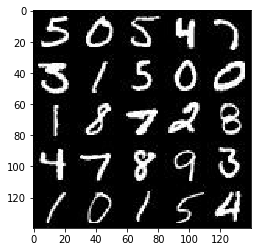

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

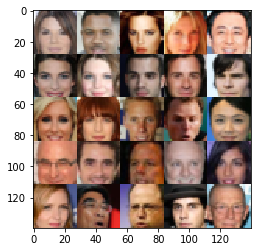

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learnin_rate')
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

I was called
Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False, alpha=0.1, prob=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 1st conv layer
        # Image Layer is 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 2nd conv layer
        # Image Layer is 14 x 14 x 64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, trainable=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop_out1 = tf.nn.dropout(relu2, keep_prob=prob)
        
        # 3rd conv layer
        # Image layer is 7 x 7 x 128
        x3 = tf.layers.conv2d(drop_out1, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, trainable=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop_out2 = tf.nn.dropout(relu3, keep_prob=prob)
        
        # Output connected layer
        # 4 x 4 x 256
        flat = tf.reshape(drop_out2, shape=(-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

I was called
I was called
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, prob=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        print('Training Value: ', is_train)
        # Input fully connected layer
        # 7 x 7 x 256
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        #Reshape to start the convolutional stack
        reshapex1 = tf.reshape(x1, (-1, 7, 7, 512))
        # Normalize
        bn = tf.layers.batch_normalization(reshapex1, training=is_train)
        conv1 = tf.maximum(alpha * bn, bn)

        # 7 x 7 x 128
        x2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides=1, padding='same')
        bn1 = tf.layers.batch_normalization(x2, training=is_train)
        conv2 = tf.maximum(alpha * bn1, bn1)
#         dropOut1 = tf.nn.dropout(conv2, keep_prob=prob)

        # 14 x 14 x 128
        x3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x3, training=is_train)
        conv3 = tf.maximum(alpha * bn2, bn2)
#         dropOut2 = tf.nn.dropout(conv3, keep_prob=prob)
        
        x4 = tf.layers.conv2d_transpose(conv3, 64, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x4, training=is_train)
        conv4 = tf.maximum(alpha * bn3, bn3)
#         dropOut3 = tf.nn.dropout(conv4, keep_prob=prob)

        logits = tf.layers.conv2d_transpose(conv4, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x 3

        out = tf.tanh(logits)
        print(out)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Training Value:  True
Tensor("Tanh:0", shape=(?, 28, 28, 5), dtype=float32)
Training Value:  False
Tensor("Tanh_1:0", shape=(?, 28, 28, 5), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator Model
    generator_model = generator(input_z, out_channel_dim)
    
    # Discriminator Model
    discr_model_real, discr_logits_real = discriminator(input_real)
    discr_model_fake, discr_logits_fake = discriminator(generator_model, True)
    
    # Discriminator Losses
    # According to the tip given here https://arxiv.org/abs/1701.00160
    # It's adviced to use a One-Sided Label Smoothing
    # The idea of one-sided label smoothing is to replace the target for the real examples with a value slightly less than one
    discr_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discr_logits_real, labels=tf.ones_like(discr_logits_real) * np.random.uniform(0.7, 1.2)))
    discr_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discr_logits_fake, labels=tf.zeros_like(discr_logits_fake) * np.random.uniform(0.0, 0.3)))
    discr_loss = discr_loss_real + discr_loss_fake
    
    # Generator Loss
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discr_logits_fake, labels=tf.ones_like(discr_model_fake)))
    
    return discr_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Training Value:  True
Tensor("generator/Tanh:0", shape=(?, 28, 28, 4), dtype=float32)
I was called
I was called
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weight and bias to update
    t_vars = tf.trainable_variables()
    descr_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    gener_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    descr_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    gener_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(descr_updates):
        descr_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=descr_vars)
        
    with tf.control_dependencies(gener_updates):
        gener_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gener_vars)
    
    return descr_opt, gener_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_op=10, show_op_imp=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discr_loss, gener_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    discr_train_opt, gener_train_opt = model_opt(discr_loss, gener_loss, learning_rate=learning_rate, beta1=beta1)
    steps=0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(discr_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(gener_train_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z, lr: learning_rate})
                
                if steps % print_op == 0:
                    train_loss_discr = discr_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_gener = gener_loss.eval({inputs_z: batch_z})
                    print("Epoch ...", (epoch_i + 1, epoch_count), " Discriminator Loss: ", train_loss_discr, " Generator Loss: ", train_loss_gener)
                    # Save losses to access after training
                    losses.append((train_loss_discr, train_loss_gener))
                
                if steps % show_op_imp == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

    # Plot
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator')
    pyplot.plot(losses.T[1], label='Generator')
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

I was called
Training Value:  True
Tensor("generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)
I was called
I was called
Epoch ... (1, 2)  Discriminator Loss:  0.787637  Generator Loss:  0.450723
Epoch ... (1, 2)  Discriminator Loss:  0.946874  Generator Loss:  0.473726
Epoch ... (1, 2)  Discriminator Loss:  1.14484  Generator Loss:  0.401348
Epoch ... (1, 2)  Discriminator Loss:  1.07256  Generator Loss:  0.450535
Epoch ... (1, 2)  Discriminator Loss:  1.46581  Generator Loss:  0.34485
Epoch ... (1, 2)  Discriminator Loss:  1.15315  Generator Loss:  0.365841
Epoch ... (1, 2)  Discriminator Loss:  1.07779  Generator Loss:  0.389005
Epoch ... (1, 2)  Discriminator Loss:  0.90609  Generator Loss:  0.467293
Epoch ... (1, 2)  Discriminator Loss:  1.07811  Generator Loss:  0.445289
Epoch ... (1, 2)  Discriminator Loss:  1.13693  Generator Loss:  0.388677
Training Value:  False
Tensor("generator_1/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


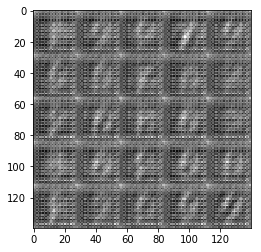

Epoch ... (1, 2)  Discriminator Loss:  1.23123  Generator Loss:  0.312485
Epoch ... (1, 2)  Discriminator Loss:  1.23391  Generator Loss:  0.270907
Epoch ... (1, 2)  Discriminator Loss:  1.3552  Generator Loss:  0.341603
Epoch ... (1, 2)  Discriminator Loss:  0.774028  Generator Loss:  0.63732
Epoch ... (1, 2)  Discriminator Loss:  1.37654  Generator Loss:  0.849144
Epoch ... (1, 2)  Discriminator Loss:  1.17056  Generator Loss:  0.78631
Epoch ... (1, 2)  Discriminator Loss:  1.24609  Generator Loss:  0.649918
Epoch ... (1, 2)  Discriminator Loss:  1.32795  Generator Loss:  0.628649
Epoch ... (1, 2)  Discriminator Loss:  1.2651  Generator Loss:  1.0868
Epoch ... (1, 2)  Discriminator Loss:  1.31824  Generator Loss:  0.704544
Training Value:  False
Tensor("generator_2/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


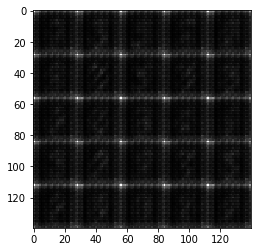

Epoch ... (1, 2)  Discriminator Loss:  1.24945  Generator Loss:  0.818076
Epoch ... (1, 2)  Discriminator Loss:  1.07257  Generator Loss:  0.61394
Epoch ... (1, 2)  Discriminator Loss:  1.17749  Generator Loss:  1.08761
Epoch ... (1, 2)  Discriminator Loss:  1.49589  Generator Loss:  0.548229
Epoch ... (1, 2)  Discriminator Loss:  1.19161  Generator Loss:  0.608914
Epoch ... (1, 2)  Discriminator Loss:  1.20184  Generator Loss:  0.599686
Epoch ... (1, 2)  Discriminator Loss:  1.40633  Generator Loss:  0.485009
Epoch ... (1, 2)  Discriminator Loss:  1.30525  Generator Loss:  0.794894
Epoch ... (1, 2)  Discriminator Loss:  1.43244  Generator Loss:  0.658556
Epoch ... (1, 2)  Discriminator Loss:  1.2215  Generator Loss:  0.813397
Training Value:  False
Tensor("generator_3/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


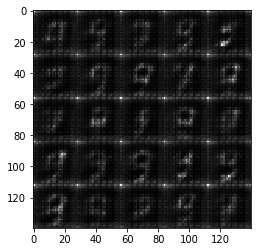

Epoch ... (1, 2)  Discriminator Loss:  1.15166  Generator Loss:  0.86889
Epoch ... (1, 2)  Discriminator Loss:  1.14074  Generator Loss:  0.653179
Epoch ... (1, 2)  Discriminator Loss:  1.30343  Generator Loss:  0.499981
Epoch ... (1, 2)  Discriminator Loss:  1.53361  Generator Loss:  1.04038
Epoch ... (1, 2)  Discriminator Loss:  1.29687  Generator Loss:  0.566192
Epoch ... (1, 2)  Discriminator Loss:  1.15036  Generator Loss:  0.648623
Epoch ... (1, 2)  Discriminator Loss:  1.2714  Generator Loss:  0.84454
Epoch ... (1, 2)  Discriminator Loss:  1.31319  Generator Loss:  0.648459
Epoch ... (1, 2)  Discriminator Loss:  1.40157  Generator Loss:  0.738633
Epoch ... (1, 2)  Discriminator Loss:  1.32133  Generator Loss:  0.615281
Training Value:  False
Tensor("generator_4/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


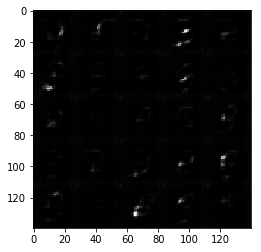

Epoch ... (1, 2)  Discriminator Loss:  1.32497  Generator Loss:  0.657812
Epoch ... (1, 2)  Discriminator Loss:  1.3424  Generator Loss:  0.590394
Epoch ... (1, 2)  Discriminator Loss:  1.36093  Generator Loss:  0.531615
Epoch ... (1, 2)  Discriminator Loss:  1.50446  Generator Loss:  0.278359
Epoch ... (1, 2)  Discriminator Loss:  1.30045  Generator Loss:  0.359451
Epoch ... (1, 2)  Discriminator Loss:  1.35933  Generator Loss:  0.536309
Epoch ... (1, 2)  Discriminator Loss:  1.24951  Generator Loss:  0.516978
Epoch ... (1, 2)  Discriminator Loss:  1.42663  Generator Loss:  0.302151
Epoch ... (1, 2)  Discriminator Loss:  1.32702  Generator Loss:  0.5081
Epoch ... (1, 2)  Discriminator Loss:  1.31991  Generator Loss:  0.575765
Training Value:  False
Tensor("generator_5/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


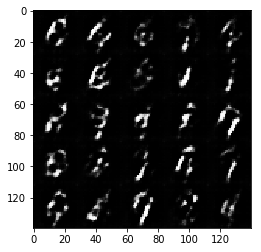

Epoch ... (1, 2)  Discriminator Loss:  1.33504  Generator Loss:  0.568553
Epoch ... (1, 2)  Discriminator Loss:  1.39954  Generator Loss:  0.598389
Epoch ... (1, 2)  Discriminator Loss:  1.36726  Generator Loss:  0.50171
Epoch ... (1, 2)  Discriminator Loss:  1.29914  Generator Loss:  0.514982
Epoch ... (1, 2)  Discriminator Loss:  1.41226  Generator Loss:  0.730862
Epoch ... (1, 2)  Discriminator Loss:  1.41203  Generator Loss:  0.470546
Epoch ... (1, 2)  Discriminator Loss:  1.41923  Generator Loss:  0.323584
Epoch ... (1, 2)  Discriminator Loss:  1.30897  Generator Loss:  0.485323
Epoch ... (1, 2)  Discriminator Loss:  1.34825  Generator Loss:  0.69978
Epoch ... (1, 2)  Discriminator Loss:  1.43187  Generator Loss:  0.430579
Training Value:  False
Tensor("generator_6/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


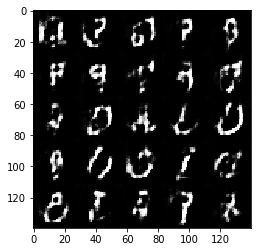

Epoch ... (1, 2)  Discriminator Loss:  1.37294  Generator Loss:  0.556652
Epoch ... (1, 2)  Discriminator Loss:  1.32064  Generator Loss:  0.623973
Epoch ... (1, 2)  Discriminator Loss:  1.38092  Generator Loss:  0.662643
Epoch ... (1, 2)  Discriminator Loss:  1.24062  Generator Loss:  0.495672
Epoch ... (1, 2)  Discriminator Loss:  1.33619  Generator Loss:  0.469506
Epoch ... (1, 2)  Discriminator Loss:  1.37956  Generator Loss:  0.316456
Epoch ... (1, 2)  Discriminator Loss:  1.33626  Generator Loss:  0.489074
Epoch ... (1, 2)  Discriminator Loss:  1.37257  Generator Loss:  0.383695
Epoch ... (1, 2)  Discriminator Loss:  1.39775  Generator Loss:  0.461397
Epoch ... (1, 2)  Discriminator Loss:  1.38116  Generator Loss:  0.387913
Training Value:  False
Tensor("generator_7/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


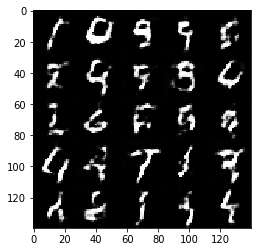

Epoch ... (1, 2)  Discriminator Loss:  1.40702  Generator Loss:  0.456713
Epoch ... (1, 2)  Discriminator Loss:  1.35278  Generator Loss:  0.620809
Epoch ... (1, 2)  Discriminator Loss:  1.30781  Generator Loss:  0.623873
Epoch ... (1, 2)  Discriminator Loss:  1.3052  Generator Loss:  0.470717
Epoch ... (1, 2)  Discriminator Loss:  1.30624  Generator Loss:  0.477177
Epoch ... (1, 2)  Discriminator Loss:  1.34941  Generator Loss:  0.600634
Epoch ... (1, 2)  Discriminator Loss:  1.38393  Generator Loss:  0.761095
Epoch ... (1, 2)  Discriminator Loss:  1.38986  Generator Loss:  0.478294
Epoch ... (1, 2)  Discriminator Loss:  1.36956  Generator Loss:  0.460434
Epoch ... (1, 2)  Discriminator Loss:  1.38668  Generator Loss:  0.483208
Training Value:  False
Tensor("generator_8/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


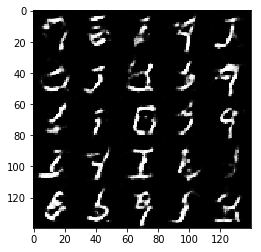

Epoch ... (1, 2)  Discriminator Loss:  1.38302  Generator Loss:  0.381394
Epoch ... (1, 2)  Discriminator Loss:  1.29569  Generator Loss:  0.427617
Epoch ... (1, 2)  Discriminator Loss:  1.39699  Generator Loss:  0.520195
Epoch ... (1, 2)  Discriminator Loss:  1.3712  Generator Loss:  0.488782
Epoch ... (1, 2)  Discriminator Loss:  1.36587  Generator Loss:  0.488623
Epoch ... (1, 2)  Discriminator Loss:  1.35125  Generator Loss:  0.448072
Epoch ... (1, 2)  Discriminator Loss:  1.3687  Generator Loss:  0.554574
Epoch ... (1, 2)  Discriminator Loss:  1.41313  Generator Loss:  0.524622
Epoch ... (1, 2)  Discriminator Loss:  1.37867  Generator Loss:  0.490987
Epoch ... (1, 2)  Discriminator Loss:  1.36004  Generator Loss:  0.495886
Training Value:  False
Tensor("generator_9/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


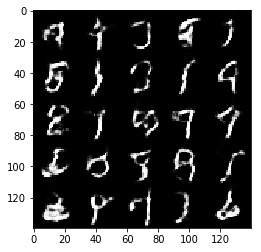

Epoch ... (1, 2)  Discriminator Loss:  1.3946  Generator Loss:  0.44231
Epoch ... (1, 2)  Discriminator Loss:  1.34101  Generator Loss:  0.446527
Epoch ... (1, 2)  Discriminator Loss:  1.38695  Generator Loss:  0.465061
Epoch ... (2, 2)  Discriminator Loss:  1.42565  Generator Loss:  0.500452
Epoch ... (2, 2)  Discriminator Loss:  1.34793  Generator Loss:  0.535192
Epoch ... (2, 2)  Discriminator Loss:  1.32704  Generator Loss:  0.513725
Epoch ... (2, 2)  Discriminator Loss:  1.39589  Generator Loss:  0.484732
Epoch ... (2, 2)  Discriminator Loss:  1.33974  Generator Loss:  0.538272
Epoch ... (2, 2)  Discriminator Loss:  1.36563  Generator Loss:  0.509503
Epoch ... (2, 2)  Discriminator Loss:  1.35738  Generator Loss:  0.53954
Training Value:  False
Tensor("generator_10/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


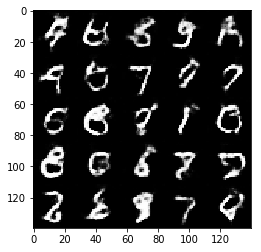

Epoch ... (2, 2)  Discriminator Loss:  1.33145  Generator Loss:  0.445416
Epoch ... (2, 2)  Discriminator Loss:  1.34176  Generator Loss:  0.603842
Epoch ... (2, 2)  Discriminator Loss:  1.34971  Generator Loss:  0.497125
Epoch ... (2, 2)  Discriminator Loss:  1.35947  Generator Loss:  0.534035
Epoch ... (2, 2)  Discriminator Loss:  1.32646  Generator Loss:  0.489961
Epoch ... (2, 2)  Discriminator Loss:  1.35583  Generator Loss:  0.499636
Epoch ... (2, 2)  Discriminator Loss:  1.38676  Generator Loss:  0.587527
Epoch ... (2, 2)  Discriminator Loss:  1.3761  Generator Loss:  0.365676
Epoch ... (2, 2)  Discriminator Loss:  1.36174  Generator Loss:  0.422529
Epoch ... (2, 2)  Discriminator Loss:  1.3663  Generator Loss:  0.52318
Training Value:  False
Tensor("generator_11/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


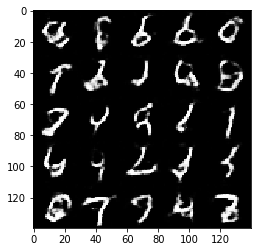

Epoch ... (2, 2)  Discriminator Loss:  1.31324  Generator Loss:  0.537245
Epoch ... (2, 2)  Discriminator Loss:  1.3282  Generator Loss:  0.473511
Epoch ... (2, 2)  Discriminator Loss:  1.35163  Generator Loss:  0.568417
Epoch ... (2, 2)  Discriminator Loss:  1.3375  Generator Loss:  0.529355
Epoch ... (2, 2)  Discriminator Loss:  1.34824  Generator Loss:  0.488234
Epoch ... (2, 2)  Discriminator Loss:  1.32701  Generator Loss:  0.499193
Epoch ... (2, 2)  Discriminator Loss:  1.37371  Generator Loss:  0.444275
Epoch ... (2, 2)  Discriminator Loss:  1.3378  Generator Loss:  0.446094
Epoch ... (2, 2)  Discriminator Loss:  1.33194  Generator Loss:  0.533236
Epoch ... (2, 2)  Discriminator Loss:  1.33543  Generator Loss:  0.486271
Training Value:  False
Tensor("generator_12/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


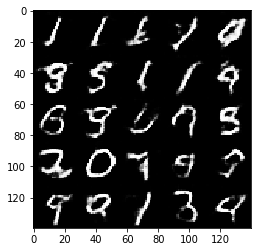

Epoch ... (2, 2)  Discriminator Loss:  1.3783  Generator Loss:  0.534209
Epoch ... (2, 2)  Discriminator Loss:  1.30089  Generator Loss:  0.474207
Epoch ... (2, 2)  Discriminator Loss:  1.31548  Generator Loss:  0.536824
Epoch ... (2, 2)  Discriminator Loss:  1.3052  Generator Loss:  0.500414
Epoch ... (2, 2)  Discriminator Loss:  1.3318  Generator Loss:  0.534173
Epoch ... (2, 2)  Discriminator Loss:  1.33278  Generator Loss:  0.479385
Epoch ... (2, 2)  Discriminator Loss:  1.33859  Generator Loss:  0.607299
Epoch ... (2, 2)  Discriminator Loss:  1.38408  Generator Loss:  0.475541
Epoch ... (2, 2)  Discriminator Loss:  1.35125  Generator Loss:  0.594417
Epoch ... (2, 2)  Discriminator Loss:  1.33425  Generator Loss:  0.54148
Training Value:  False
Tensor("generator_13/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


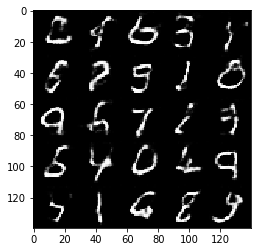

Epoch ... (2, 2)  Discriminator Loss:  1.36405  Generator Loss:  0.424666
Epoch ... (2, 2)  Discriminator Loss:  1.36121  Generator Loss:  0.472656
Epoch ... (2, 2)  Discriminator Loss:  1.35731  Generator Loss:  0.515948
Epoch ... (2, 2)  Discriminator Loss:  1.37663  Generator Loss:  0.51828
Epoch ... (2, 2)  Discriminator Loss:  1.37332  Generator Loss:  0.498587
Epoch ... (2, 2)  Discriminator Loss:  1.29467  Generator Loss:  0.500283
Epoch ... (2, 2)  Discriminator Loss:  1.32001  Generator Loss:  0.573509
Epoch ... (2, 2)  Discriminator Loss:  1.33706  Generator Loss:  0.522076
Epoch ... (2, 2)  Discriminator Loss:  1.30821  Generator Loss:  0.506676
Epoch ... (2, 2)  Discriminator Loss:  1.27776  Generator Loss:  0.51211
Training Value:  False
Tensor("generator_14/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


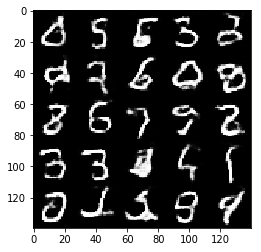

Epoch ... (2, 2)  Discriminator Loss:  1.31352  Generator Loss:  0.540223
Epoch ... (2, 2)  Discriminator Loss:  1.35514  Generator Loss:  0.51414
Epoch ... (2, 2)  Discriminator Loss:  1.32971  Generator Loss:  0.513595
Epoch ... (2, 2)  Discriminator Loss:  1.3166  Generator Loss:  0.466142
Epoch ... (2, 2)  Discriminator Loss:  1.33995  Generator Loss:  0.527197
Epoch ... (2, 2)  Discriminator Loss:  1.32532  Generator Loss:  0.46992
Epoch ... (2, 2)  Discriminator Loss:  1.37169  Generator Loss:  0.488928
Epoch ... (2, 2)  Discriminator Loss:  1.33391  Generator Loss:  0.501028
Epoch ... (2, 2)  Discriminator Loss:  1.3459  Generator Loss:  0.527747
Epoch ... (2, 2)  Discriminator Loss:  1.35765  Generator Loss:  0.517618
Training Value:  False
Tensor("generator_15/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


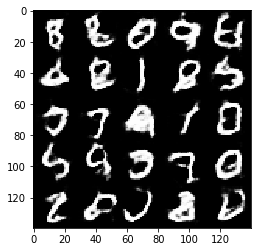

Epoch ... (2, 2)  Discriminator Loss:  1.33721  Generator Loss:  0.461219
Epoch ... (2, 2)  Discriminator Loss:  1.37267  Generator Loss:  0.559889
Epoch ... (2, 2)  Discriminator Loss:  1.33878  Generator Loss:  0.571564
Epoch ... (2, 2)  Discriminator Loss:  1.35516  Generator Loss:  0.458903
Epoch ... (2, 2)  Discriminator Loss:  1.34514  Generator Loss:  0.54053
Epoch ... (2, 2)  Discriminator Loss:  1.3083  Generator Loss:  0.42886
Epoch ... (2, 2)  Discriminator Loss:  1.34455  Generator Loss:  0.501084
Epoch ... (2, 2)  Discriminator Loss:  1.33093  Generator Loss:  0.537382
Epoch ... (2, 2)  Discriminator Loss:  1.29158  Generator Loss:  0.506629
Epoch ... (2, 2)  Discriminator Loss:  1.30284  Generator Loss:  0.524738
Training Value:  False
Tensor("generator_16/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


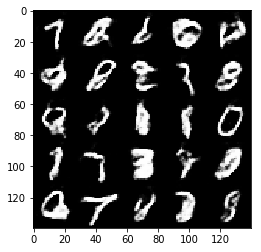

Epoch ... (2, 2)  Discriminator Loss:  1.32369  Generator Loss:  0.422496
Epoch ... (2, 2)  Discriminator Loss:  1.36647  Generator Loss:  0.582968
Epoch ... (2, 2)  Discriminator Loss:  1.36527  Generator Loss:  0.52498
Epoch ... (2, 2)  Discriminator Loss:  1.31913  Generator Loss:  0.48711
Epoch ... (2, 2)  Discriminator Loss:  1.31301  Generator Loss:  0.548567
Epoch ... (2, 2)  Discriminator Loss:  1.32338  Generator Loss:  0.563365
Epoch ... (2, 2)  Discriminator Loss:  1.33232  Generator Loss:  0.505104
Epoch ... (2, 2)  Discriminator Loss:  1.30146  Generator Loss:  0.498343
Epoch ... (2, 2)  Discriminator Loss:  1.33859  Generator Loss:  0.531703
Epoch ... (2, 2)  Discriminator Loss:  1.29148  Generator Loss:  0.616948
Training Value:  False
Tensor("generator_17/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


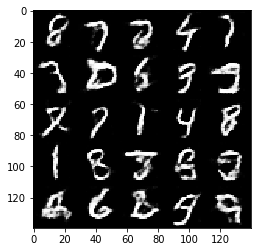

Epoch ... (2, 2)  Discriminator Loss:  1.35875  Generator Loss:  0.594938
Epoch ... (2, 2)  Discriminator Loss:  1.31299  Generator Loss:  0.458537
Epoch ... (2, 2)  Discriminator Loss:  1.31303  Generator Loss:  0.536058
Epoch ... (2, 2)  Discriminator Loss:  1.30757  Generator Loss:  0.561108
Epoch ... (2, 2)  Discriminator Loss:  1.31244  Generator Loss:  0.482424
Epoch ... (2, 2)  Discriminator Loss:  1.33217  Generator Loss:  0.471279
Epoch ... (2, 2)  Discriminator Loss:  1.32662  Generator Loss:  0.592946
Epoch ... (2, 2)  Discriminator Loss:  1.3233  Generator Loss:  0.510598
Epoch ... (2, 2)  Discriminator Loss:  1.37064  Generator Loss:  0.392533
Epoch ... (2, 2)  Discriminator Loss:  1.33385  Generator Loss:  0.490982
Training Value:  False
Tensor("generator_18/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


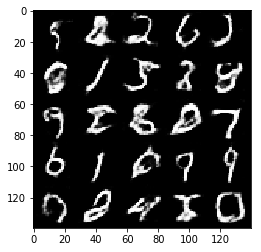

Epoch ... (2, 2)  Discriminator Loss:  1.32531  Generator Loss:  0.47126
Epoch ... (2, 2)  Discriminator Loss:  1.35939  Generator Loss:  0.406645
Epoch ... (2, 2)  Discriminator Loss:  1.32095  Generator Loss:  0.416269
Epoch ... (2, 2)  Discriminator Loss:  1.33454  Generator Loss:  0.521079
Epoch ... (2, 2)  Discriminator Loss:  1.31548  Generator Loss:  0.517324
Epoch ... (2, 2)  Discriminator Loss:  1.29685  Generator Loss:  0.52308
Epoch ... (2, 2)  Discriminator Loss:  1.3658  Generator Loss:  0.577898


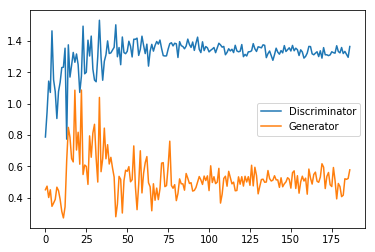

In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

I was called
Training Value:  True
Tensor("generator/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)
I was called
I was called
Epoch ... (1, 1)  Discriminator Loss:  1.23305  Generator Loss:  0.635014
Epoch ... (1, 1)  Discriminator Loss:  1.23663  Generator Loss:  0.719067
Epoch ... (1, 1)  Discriminator Loss:  1.28749  Generator Loss:  0.732099
Epoch ... (1, 1)  Discriminator Loss:  1.23609  Generator Loss:  0.79871
Epoch ... (1, 1)  Discriminator Loss:  1.60045  Generator Loss:  0.574036
Epoch ... (1, 1)  Discriminator Loss:  1.12573  Generator Loss:  0.975678
Epoch ... (1, 1)  Discriminator Loss:  1.35409  Generator Loss:  0.810694
Epoch ... (1, 1)  Discriminator Loss:  1.32374  Generator Loss:  0.743811
Epoch ... (1, 1)  Discriminator Loss:  1.264  Generator Loss:  0.796687
Epoch ... (1, 1)  Discriminator Loss:  1.26044  Generator Loss:  0.810849
Training Value:  False
Tensor("generator_1/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


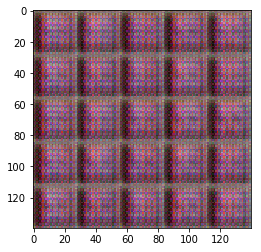

Epoch ... (1, 1)  Discriminator Loss:  1.23043  Generator Loss:  0.808428
Epoch ... (1, 1)  Discriminator Loss:  1.5536  Generator Loss:  0.750775
Epoch ... (1, 1)  Discriminator Loss:  1.16512  Generator Loss:  0.806276
Epoch ... (1, 1)  Discriminator Loss:  1.511  Generator Loss:  0.70067
Epoch ... (1, 1)  Discriminator Loss:  1.43087  Generator Loss:  0.650458
Epoch ... (1, 1)  Discriminator Loss:  1.26438  Generator Loss:  0.877597
Epoch ... (1, 1)  Discriminator Loss:  1.40078  Generator Loss:  0.862373
Epoch ... (1, 1)  Discriminator Loss:  1.36333  Generator Loss:  0.716792
Epoch ... (1, 1)  Discriminator Loss:  1.46555  Generator Loss:  0.731715
Epoch ... (1, 1)  Discriminator Loss:  1.1905  Generator Loss:  1.00213
Training Value:  False
Tensor("generator_2/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


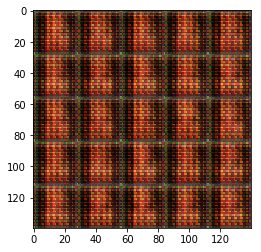

Epoch ... (1, 1)  Discriminator Loss:  1.33226  Generator Loss:  0.703346
Epoch ... (1, 1)  Discriminator Loss:  1.00387  Generator Loss:  1.05708
Epoch ... (1, 1)  Discriminator Loss:  1.50018  Generator Loss:  0.823164
Epoch ... (1, 1)  Discriminator Loss:  1.36189  Generator Loss:  0.809004
Epoch ... (1, 1)  Discriminator Loss:  1.18191  Generator Loss:  0.879964
Epoch ... (1, 1)  Discriminator Loss:  1.29868  Generator Loss:  0.817616
Epoch ... (1, 1)  Discriminator Loss:  1.31687  Generator Loss:  0.833438
Epoch ... (1, 1)  Discriminator Loss:  1.22976  Generator Loss:  0.804281
Epoch ... (1, 1)  Discriminator Loss:  0.977367  Generator Loss:  0.976521
Epoch ... (1, 1)  Discriminator Loss:  1.23755  Generator Loss:  0.883604
Training Value:  False
Tensor("generator_3/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


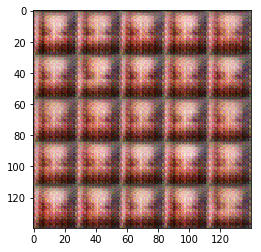

Epoch ... (1, 1)  Discriminator Loss:  1.08092  Generator Loss:  0.9966
Epoch ... (1, 1)  Discriminator Loss:  1.1395  Generator Loss:  0.992088
Epoch ... (1, 1)  Discriminator Loss:  1.42739  Generator Loss:  0.643392
Epoch ... (1, 1)  Discriminator Loss:  1.22004  Generator Loss:  0.773344
Epoch ... (1, 1)  Discriminator Loss:  1.03649  Generator Loss:  0.917937
Epoch ... (1, 1)  Discriminator Loss:  1.25732  Generator Loss:  0.842028
Epoch ... (1, 1)  Discriminator Loss:  1.04873  Generator Loss:  0.943439
Epoch ... (1, 1)  Discriminator Loss:  1.12913  Generator Loss:  1.27522
Epoch ... (1, 1)  Discriminator Loss:  1.4557  Generator Loss:  0.679785
Epoch ... (1, 1)  Discriminator Loss:  1.77921  Generator Loss:  0.848563
Training Value:  False
Tensor("generator_4/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


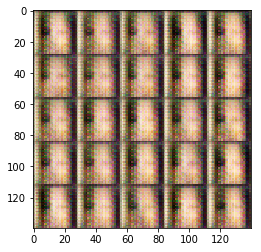

Epoch ... (1, 1)  Discriminator Loss:  1.03274  Generator Loss:  1.00755
Epoch ... (1, 1)  Discriminator Loss:  1.1948  Generator Loss:  0.929289
Epoch ... (1, 1)  Discriminator Loss:  1.34996  Generator Loss:  0.867838
Epoch ... (1, 1)  Discriminator Loss:  0.98547  Generator Loss:  0.966291
Epoch ... (1, 1)  Discriminator Loss:  1.23341  Generator Loss:  1.07759
Epoch ... (1, 1)  Discriminator Loss:  1.15529  Generator Loss:  0.931521
Epoch ... (1, 1)  Discriminator Loss:  1.25081  Generator Loss:  0.741582
Epoch ... (1, 1)  Discriminator Loss:  1.45378  Generator Loss:  0.874888
Epoch ... (1, 1)  Discriminator Loss:  1.1079  Generator Loss:  1.00666
Epoch ... (1, 1)  Discriminator Loss:  1.05809  Generator Loss:  0.910934
Training Value:  False
Tensor("generator_5/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


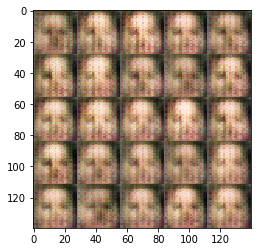

Epoch ... (1, 1)  Discriminator Loss:  1.26003  Generator Loss:  0.849952
Epoch ... (1, 1)  Discriminator Loss:  1.339  Generator Loss:  0.760156
Epoch ... (1, 1)  Discriminator Loss:  0.91482  Generator Loss:  1.07007
Epoch ... (1, 1)  Discriminator Loss:  1.15299  Generator Loss:  0.809808
Epoch ... (1, 1)  Discriminator Loss:  1.53442  Generator Loss:  0.695015
Epoch ... (1, 1)  Discriminator Loss:  1.14569  Generator Loss:  0.957286
Epoch ... (1, 1)  Discriminator Loss:  0.986304  Generator Loss:  1.1378
Epoch ... (1, 1)  Discriminator Loss:  1.4019  Generator Loss:  0.801867
Epoch ... (1, 1)  Discriminator Loss:  1.17045  Generator Loss:  0.878009
Epoch ... (1, 1)  Discriminator Loss:  1.12993  Generator Loss:  0.821471
Training Value:  False
Tensor("generator_6/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


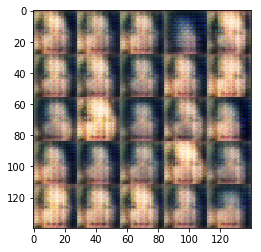

Epoch ... (1, 1)  Discriminator Loss:  1.37127  Generator Loss:  0.767846
Epoch ... (1, 1)  Discriminator Loss:  1.07396  Generator Loss:  0.855446
Epoch ... (1, 1)  Discriminator Loss:  1.86735  Generator Loss:  0.717982
Epoch ... (1, 1)  Discriminator Loss:  1.03789  Generator Loss:  0.947091
Epoch ... (1, 1)  Discriminator Loss:  1.16603  Generator Loss:  0.894932
Epoch ... (1, 1)  Discriminator Loss:  1.38709  Generator Loss:  0.795267
Epoch ... (1, 1)  Discriminator Loss:  1.21261  Generator Loss:  0.858915
Epoch ... (1, 1)  Discriminator Loss:  1.72664  Generator Loss:  0.707349
Epoch ... (1, 1)  Discriminator Loss:  1.26922  Generator Loss:  0.900623
Epoch ... (1, 1)  Discriminator Loss:  1.27088  Generator Loss:  0.812462
Training Value:  False
Tensor("generator_7/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


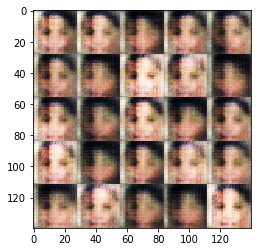

Epoch ... (1, 1)  Discriminator Loss:  1.19348  Generator Loss:  0.816974
Epoch ... (1, 1)  Discriminator Loss:  1.43385  Generator Loss:  0.793914
Epoch ... (1, 1)  Discriminator Loss:  1.17049  Generator Loss:  0.905592
Epoch ... (1, 1)  Discriminator Loss:  1.338  Generator Loss:  0.839605
Epoch ... (1, 1)  Discriminator Loss:  1.19499  Generator Loss:  0.874329
Epoch ... (1, 1)  Discriminator Loss:  1.25595  Generator Loss:  0.877833
Epoch ... (1, 1)  Discriminator Loss:  1.12763  Generator Loss:  0.87167
Epoch ... (1, 1)  Discriminator Loss:  1.2534  Generator Loss:  0.862373
Epoch ... (1, 1)  Discriminator Loss:  1.3178  Generator Loss:  0.858916
Epoch ... (1, 1)  Discriminator Loss:  1.15924  Generator Loss:  0.864593
Training Value:  False
Tensor("generator_8/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


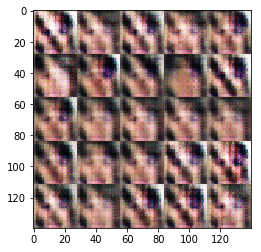

Epoch ... (1, 1)  Discriminator Loss:  1.2381  Generator Loss:  0.77182
Epoch ... (1, 1)  Discriminator Loss:  0.903952  Generator Loss:  1.18014
Epoch ... (1, 1)  Discriminator Loss:  1.84111  Generator Loss:  0.68714
Epoch ... (1, 1)  Discriminator Loss:  1.50482  Generator Loss:  0.727417
Epoch ... (1, 1)  Discriminator Loss:  1.18844  Generator Loss:  0.920174
Epoch ... (1, 1)  Discriminator Loss:  1.36344  Generator Loss:  0.751889
Epoch ... (1, 1)  Discriminator Loss:  1.36425  Generator Loss:  0.77668
Epoch ... (1, 1)  Discriminator Loss:  1.26622  Generator Loss:  0.86445
Epoch ... (1, 1)  Discriminator Loss:  1.2635  Generator Loss:  0.770562
Epoch ... (1, 1)  Discriminator Loss:  1.23438  Generator Loss:  0.842404
Training Value:  False
Tensor("generator_9/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


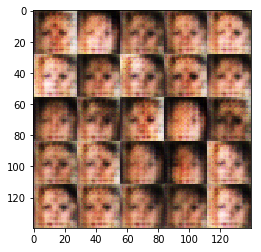

Epoch ... (1, 1)  Discriminator Loss:  1.27184  Generator Loss:  0.811987
Epoch ... (1, 1)  Discriminator Loss:  1.22743  Generator Loss:  0.838143
Epoch ... (1, 1)  Discriminator Loss:  1.36062  Generator Loss:  0.770955
Epoch ... (1, 1)  Discriminator Loss:  1.22687  Generator Loss:  0.84329
Epoch ... (1, 1)  Discriminator Loss:  1.27941  Generator Loss:  0.737182
Epoch ... (1, 1)  Discriminator Loss:  1.34532  Generator Loss:  0.754095
Epoch ... (1, 1)  Discriminator Loss:  1.22664  Generator Loss:  0.893003
Epoch ... (1, 1)  Discriminator Loss:  1.50935  Generator Loss:  0.6845
Epoch ... (1, 1)  Discriminator Loss:  1.27238  Generator Loss:  0.803998
Epoch ... (1, 1)  Discriminator Loss:  1.36483  Generator Loss:  0.774538
Training Value:  False
Tensor("generator_10/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


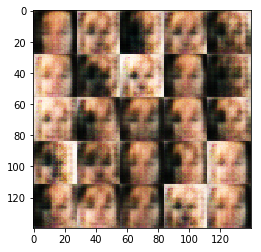

Epoch ... (1, 1)  Discriminator Loss:  1.2903  Generator Loss:  0.772149
Epoch ... (1, 1)  Discriminator Loss:  1.35706  Generator Loss:  0.740933
Epoch ... (1, 1)  Discriminator Loss:  1.36806  Generator Loss:  0.779799
Epoch ... (1, 1)  Discriminator Loss:  1.34266  Generator Loss:  0.811143
Epoch ... (1, 1)  Discriminator Loss:  1.28262  Generator Loss:  0.824377
Epoch ... (1, 1)  Discriminator Loss:  1.21891  Generator Loss:  0.842572
Epoch ... (1, 1)  Discriminator Loss:  1.18034  Generator Loss:  0.795912
Epoch ... (1, 1)  Discriminator Loss:  1.4888  Generator Loss:  0.735679
Epoch ... (1, 1)  Discriminator Loss:  1.12639  Generator Loss:  0.934501
Epoch ... (1, 1)  Discriminator Loss:  1.18598  Generator Loss:  0.849959
Training Value:  False
Tensor("generator_11/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


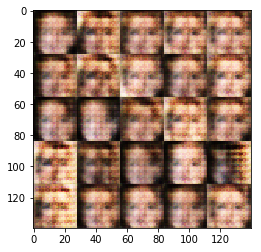

Epoch ... (1, 1)  Discriminator Loss:  1.44049  Generator Loss:  0.740529
Epoch ... (1, 1)  Discriminator Loss:  1.25529  Generator Loss:  0.771906
Epoch ... (1, 1)  Discriminator Loss:  1.37129  Generator Loss:  0.843671
Epoch ... (1, 1)  Discriminator Loss:  1.19325  Generator Loss:  0.913056
Epoch ... (1, 1)  Discriminator Loss:  1.39924  Generator Loss:  0.76545
Epoch ... (1, 1)  Discriminator Loss:  1.28084  Generator Loss:  0.815368
Epoch ... (1, 1)  Discriminator Loss:  1.28634  Generator Loss:  0.767992
Epoch ... (1, 1)  Discriminator Loss:  1.13109  Generator Loss:  0.82744
Epoch ... (1, 1)  Discriminator Loss:  1.1897  Generator Loss:  0.831592
Epoch ... (1, 1)  Discriminator Loss:  1.24368  Generator Loss:  0.841408
Training Value:  False
Tensor("generator_12/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


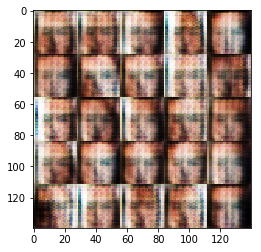

Epoch ... (1, 1)  Discriminator Loss:  1.36909  Generator Loss:  0.839493
Epoch ... (1, 1)  Discriminator Loss:  1.35919  Generator Loss:  0.870908
Epoch ... (1, 1)  Discriminator Loss:  1.08012  Generator Loss:  1.02672
Epoch ... (1, 1)  Discriminator Loss:  1.39937  Generator Loss:  0.747195
Epoch ... (1, 1)  Discriminator Loss:  1.31473  Generator Loss:  0.748657
Epoch ... (1, 1)  Discriminator Loss:  1.26121  Generator Loss:  0.806946
Epoch ... (1, 1)  Discriminator Loss:  1.17495  Generator Loss:  0.862878
Epoch ... (1, 1)  Discriminator Loss:  1.34639  Generator Loss:  0.797967
Epoch ... (1, 1)  Discriminator Loss:  1.19278  Generator Loss:  0.769261
Epoch ... (1, 1)  Discriminator Loss:  1.33797  Generator Loss:  0.76317
Training Value:  False
Tensor("generator_13/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


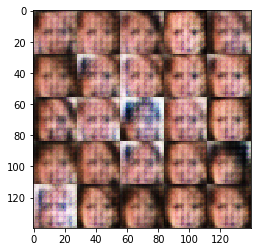

Epoch ... (1, 1)  Discriminator Loss:  1.37325  Generator Loss:  0.769026
Epoch ... (1, 1)  Discriminator Loss:  1.21737  Generator Loss:  0.832023
Epoch ... (1, 1)  Discriminator Loss:  1.35169  Generator Loss:  0.742666
Epoch ... (1, 1)  Discriminator Loss:  1.24825  Generator Loss:  0.774448
Epoch ... (1, 1)  Discriminator Loss:  1.32119  Generator Loss:  0.780107
Epoch ... (1, 1)  Discriminator Loss:  1.25735  Generator Loss:  0.89935
Epoch ... (1, 1)  Discriminator Loss:  1.28505  Generator Loss:  0.874398
Epoch ... (1, 1)  Discriminator Loss:  1.47565  Generator Loss:  0.775923
Epoch ... (1, 1)  Discriminator Loss:  1.13445  Generator Loss:  0.908934
Epoch ... (1, 1)  Discriminator Loss:  1.48283  Generator Loss:  0.741722
Training Value:  False
Tensor("generator_14/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


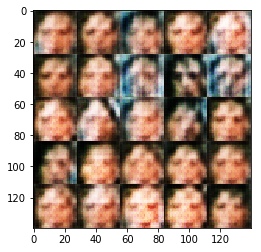

Epoch ... (1, 1)  Discriminator Loss:  1.22558  Generator Loss:  0.857871
Epoch ... (1, 1)  Discriminator Loss:  1.35314  Generator Loss:  0.792482
Epoch ... (1, 1)  Discriminator Loss:  1.25043  Generator Loss:  0.812981
Epoch ... (1, 1)  Discriminator Loss:  1.38509  Generator Loss:  0.698382
Epoch ... (1, 1)  Discriminator Loss:  1.31866  Generator Loss:  0.822466
Epoch ... (1, 1)  Discriminator Loss:  1.17675  Generator Loss:  0.952968
Epoch ... (1, 1)  Discriminator Loss:  1.32895  Generator Loss:  0.708286
Epoch ... (1, 1)  Discriminator Loss:  1.22357  Generator Loss:  0.828153
Epoch ... (1, 1)  Discriminator Loss:  1.2416  Generator Loss:  0.785217
Epoch ... (1, 1)  Discriminator Loss:  1.15655  Generator Loss:  0.807692
Training Value:  False
Tensor("generator_15/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


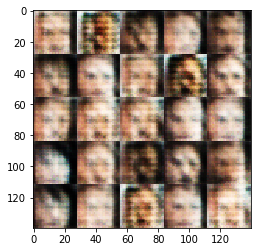

Epoch ... (1, 1)  Discriminator Loss:  1.3725  Generator Loss:  0.732052
Epoch ... (1, 1)  Discriminator Loss:  1.37266  Generator Loss:  0.65435
Epoch ... (1, 1)  Discriminator Loss:  1.35012  Generator Loss:  0.816744
Epoch ... (1, 1)  Discriminator Loss:  1.29003  Generator Loss:  0.802185
Epoch ... (1, 1)  Discriminator Loss:  1.31941  Generator Loss:  0.855186
Epoch ... (1, 1)  Discriminator Loss:  1.23515  Generator Loss:  0.834883
Epoch ... (1, 1)  Discriminator Loss:  1.36166  Generator Loss:  0.728223
Epoch ... (1, 1)  Discriminator Loss:  1.24716  Generator Loss:  0.834704
Epoch ... (1, 1)  Discriminator Loss:  1.27301  Generator Loss:  0.839538
Epoch ... (1, 1)  Discriminator Loss:  1.1432  Generator Loss:  0.914328
Training Value:  False
Tensor("generator_16/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


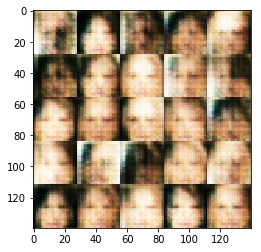

Epoch ... (1, 1)  Discriminator Loss:  1.30177  Generator Loss:  0.7548
Epoch ... (1, 1)  Discriminator Loss:  1.49688  Generator Loss:  0.705628
Epoch ... (1, 1)  Discriminator Loss:  1.27425  Generator Loss:  0.873728
Epoch ... (1, 1)  Discriminator Loss:  1.25907  Generator Loss:  0.809584
Epoch ... (1, 1)  Discriminator Loss:  1.20729  Generator Loss:  0.790603
Epoch ... (1, 1)  Discriminator Loss:  1.38368  Generator Loss:  0.915647
Epoch ... (1, 1)  Discriminator Loss:  1.42864  Generator Loss:  0.845746
Epoch ... (1, 1)  Discriminator Loss:  1.3314  Generator Loss:  0.818754
Epoch ... (1, 1)  Discriminator Loss:  1.45135  Generator Loss:  0.754183
Epoch ... (1, 1)  Discriminator Loss:  1.2579  Generator Loss:  0.931157
Training Value:  False
Tensor("generator_17/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


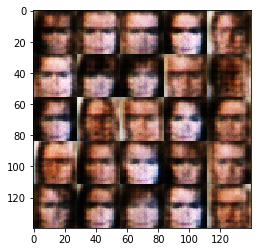

Epoch ... (1, 1)  Discriminator Loss:  1.28796  Generator Loss:  0.842187
Epoch ... (1, 1)  Discriminator Loss:  1.22744  Generator Loss:  0.747801
Epoch ... (1, 1)  Discriminator Loss:  1.24203  Generator Loss:  0.790376
Epoch ... (1, 1)  Discriminator Loss:  1.32166  Generator Loss:  0.786588
Epoch ... (1, 1)  Discriminator Loss:  1.22327  Generator Loss:  0.883157
Epoch ... (1, 1)  Discriminator Loss:  1.05501  Generator Loss:  0.876511
Epoch ... (1, 1)  Discriminator Loss:  1.19559  Generator Loss:  0.784807
Epoch ... (1, 1)  Discriminator Loss:  1.20022  Generator Loss:  0.845733
Epoch ... (1, 1)  Discriminator Loss:  1.38256  Generator Loss:  0.678001
Epoch ... (1, 1)  Discriminator Loss:  1.40749  Generator Loss:  0.856914
Training Value:  False
Tensor("generator_18/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


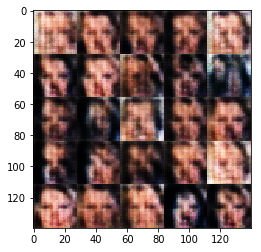

Epoch ... (1, 1)  Discriminator Loss:  1.33083  Generator Loss:  0.775761
Epoch ... (1, 1)  Discriminator Loss:  1.24447  Generator Loss:  0.752862
Epoch ... (1, 1)  Discriminator Loss:  1.23364  Generator Loss:  0.877099
Epoch ... (1, 1)  Discriminator Loss:  1.34244  Generator Loss:  0.765461
Epoch ... (1, 1)  Discriminator Loss:  1.32932  Generator Loss:  0.815413
Epoch ... (1, 1)  Discriminator Loss:  1.29686  Generator Loss:  0.692441
Epoch ... (1, 1)  Discriminator Loss:  1.2194  Generator Loss:  0.769896
Epoch ... (1, 1)  Discriminator Loss:  1.45438  Generator Loss:  0.670265
Epoch ... (1, 1)  Discriminator Loss:  1.33653  Generator Loss:  0.748945
Epoch ... (1, 1)  Discriminator Loss:  1.27603  Generator Loss:  0.878705
Training Value:  False
Tensor("generator_19/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


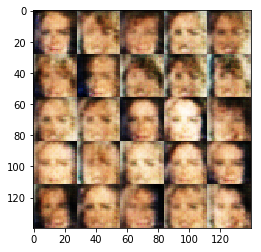

Epoch ... (1, 1)  Discriminator Loss:  1.39242  Generator Loss:  0.81284
Epoch ... (1, 1)  Discriminator Loss:  1.23413  Generator Loss:  0.801486
Epoch ... (1, 1)  Discriminator Loss:  1.22622  Generator Loss:  0.765643
Epoch ... (1, 1)  Discriminator Loss:  1.13934  Generator Loss:  0.906625
Epoch ... (1, 1)  Discriminator Loss:  1.36195  Generator Loss:  0.77751
Epoch ... (1, 1)  Discriminator Loss:  1.40399  Generator Loss:  0.773991
Epoch ... (1, 1)  Discriminator Loss:  1.33485  Generator Loss:  0.817997
Epoch ... (1, 1)  Discriminator Loss:  1.3473  Generator Loss:  0.77303
Epoch ... (1, 1)  Discriminator Loss:  1.34308  Generator Loss:  0.765723
Epoch ... (1, 1)  Discriminator Loss:  1.314  Generator Loss:  0.816278
Training Value:  False
Tensor("generator_20/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


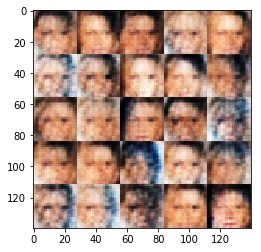

Epoch ... (1, 1)  Discriminator Loss:  1.24641  Generator Loss:  0.790385
Epoch ... (1, 1)  Discriminator Loss:  1.43387  Generator Loss:  0.741543
Epoch ... (1, 1)  Discriminator Loss:  1.33412  Generator Loss:  0.776878
Epoch ... (1, 1)  Discriminator Loss:  1.2486  Generator Loss:  0.804621
Epoch ... (1, 1)  Discriminator Loss:  1.34262  Generator Loss:  0.788453
Epoch ... (1, 1)  Discriminator Loss:  1.29017  Generator Loss:  0.790304
Epoch ... (1, 1)  Discriminator Loss:  1.1548  Generator Loss:  0.798202
Epoch ... (1, 1)  Discriminator Loss:  1.29663  Generator Loss:  0.793354
Epoch ... (1, 1)  Discriminator Loss:  1.33787  Generator Loss:  0.762172
Epoch ... (1, 1)  Discriminator Loss:  1.25907  Generator Loss:  0.79702
Training Value:  False
Tensor("generator_21/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


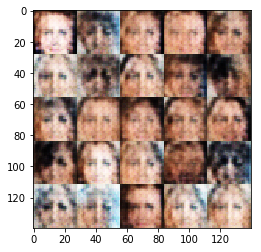

Epoch ... (1, 1)  Discriminator Loss:  1.42966  Generator Loss:  0.742383
Epoch ... (1, 1)  Discriminator Loss:  1.35522  Generator Loss:  0.809176
Epoch ... (1, 1)  Discriminator Loss:  1.30067  Generator Loss:  0.849824
Epoch ... (1, 1)  Discriminator Loss:  1.1802  Generator Loss:  0.916333
Epoch ... (1, 1)  Discriminator Loss:  1.24547  Generator Loss:  0.805485
Epoch ... (1, 1)  Discriminator Loss:  1.41609  Generator Loss:  0.787788
Epoch ... (1, 1)  Discriminator Loss:  1.27279  Generator Loss:  0.81703
Epoch ... (1, 1)  Discriminator Loss:  1.30121  Generator Loss:  0.809535
Epoch ... (1, 1)  Discriminator Loss:  1.26689  Generator Loss:  0.776211
Epoch ... (1, 1)  Discriminator Loss:  1.20108  Generator Loss:  0.728318
Training Value:  False
Tensor("generator_22/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


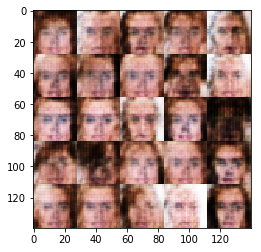

Epoch ... (1, 1)  Discriminator Loss:  1.36468  Generator Loss:  0.775078
Epoch ... (1, 1)  Discriminator Loss:  1.33351  Generator Loss:  0.796262
Epoch ... (1, 1)  Discriminator Loss:  1.2939  Generator Loss:  0.795775
Epoch ... (1, 1)  Discriminator Loss:  1.34354  Generator Loss:  0.819262
Epoch ... (1, 1)  Discriminator Loss:  1.16291  Generator Loss:  0.815737
Epoch ... (1, 1)  Discriminator Loss:  1.27748  Generator Loss:  0.88826
Epoch ... (1, 1)  Discriminator Loss:  1.39051  Generator Loss:  0.797257
Epoch ... (1, 1)  Discriminator Loss:  1.64295  Generator Loss:  0.772058
Epoch ... (1, 1)  Discriminator Loss:  1.21312  Generator Loss:  0.872435
Epoch ... (1, 1)  Discriminator Loss:  1.13909  Generator Loss:  0.880364
Training Value:  False
Tensor("generator_23/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


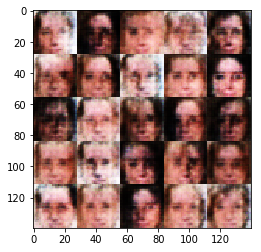

Epoch ... (1, 1)  Discriminator Loss:  1.52829  Generator Loss:  0.774348
Epoch ... (1, 1)  Discriminator Loss:  1.32422  Generator Loss:  0.784477
Epoch ... (1, 1)  Discriminator Loss:  1.21267  Generator Loss:  0.827513
Epoch ... (1, 1)  Discriminator Loss:  1.27005  Generator Loss:  0.91748
Epoch ... (1, 1)  Discriminator Loss:  1.181  Generator Loss:  0.830607
Epoch ... (1, 1)  Discriminator Loss:  1.44833  Generator Loss:  0.726299
Epoch ... (1, 1)  Discriminator Loss:  1.35644  Generator Loss:  0.700876
Epoch ... (1, 1)  Discriminator Loss:  1.30327  Generator Loss:  0.7482
Epoch ... (1, 1)  Discriminator Loss:  1.34946  Generator Loss:  0.792268
Epoch ... (1, 1)  Discriminator Loss:  1.35402  Generator Loss:  0.796713
Training Value:  False
Tensor("generator_24/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


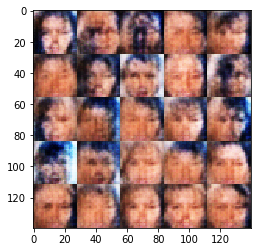

Epoch ... (1, 1)  Discriminator Loss:  1.38124  Generator Loss:  0.778165
Epoch ... (1, 1)  Discriminator Loss:  1.30194  Generator Loss:  0.881092
Epoch ... (1, 1)  Discriminator Loss:  1.39326  Generator Loss:  0.793575
Epoch ... (1, 1)  Discriminator Loss:  1.40896  Generator Loss:  0.758575
Epoch ... (1, 1)  Discriminator Loss:  1.25321  Generator Loss:  0.8421
Epoch ... (1, 1)  Discriminator Loss:  1.35665  Generator Loss:  0.714084
Epoch ... (1, 1)  Discriminator Loss:  1.36083  Generator Loss:  0.814217
Epoch ... (1, 1)  Discriminator Loss:  1.36002  Generator Loss:  0.735293
Epoch ... (1, 1)  Discriminator Loss:  1.41989  Generator Loss:  0.732524
Epoch ... (1, 1)  Discriminator Loss:  1.28031  Generator Loss:  0.803221
Training Value:  False
Tensor("generator_25/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


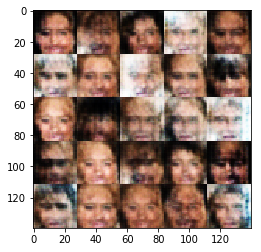

Epoch ... (1, 1)  Discriminator Loss:  1.21982  Generator Loss:  0.830568
Epoch ... (1, 1)  Discriminator Loss:  1.32377  Generator Loss:  0.894291
Epoch ... (1, 1)  Discriminator Loss:  1.33129  Generator Loss:  0.835553
Epoch ... (1, 1)  Discriminator Loss:  1.30554  Generator Loss:  0.818485
Epoch ... (1, 1)  Discriminator Loss:  1.17315  Generator Loss:  0.814502
Epoch ... (1, 1)  Discriminator Loss:  1.32957  Generator Loss:  0.743338
Epoch ... (1, 1)  Discriminator Loss:  1.33583  Generator Loss:  0.745512
Epoch ... (1, 1)  Discriminator Loss:  1.39445  Generator Loss:  0.784461
Epoch ... (1, 1)  Discriminator Loss:  1.35476  Generator Loss:  0.838008
Epoch ... (1, 1)  Discriminator Loss:  1.25096  Generator Loss:  0.814877
Training Value:  False
Tensor("generator_26/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


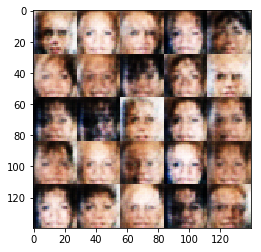

Epoch ... (1, 1)  Discriminator Loss:  1.32377  Generator Loss:  0.694275
Epoch ... (1, 1)  Discriminator Loss:  1.33867  Generator Loss:  0.73152
Epoch ... (1, 1)  Discriminator Loss:  1.34533  Generator Loss:  0.694817
Epoch ... (1, 1)  Discriminator Loss:  1.34149  Generator Loss:  0.760307
Epoch ... (1, 1)  Discriminator Loss:  1.38146  Generator Loss:  0.716458
Epoch ... (1, 1)  Discriminator Loss:  1.39607  Generator Loss:  0.793786
Epoch ... (1, 1)  Discriminator Loss:  1.315  Generator Loss:  0.764308
Epoch ... (1, 1)  Discriminator Loss:  1.34121  Generator Loss:  0.790263
Epoch ... (1, 1)  Discriminator Loss:  1.36714  Generator Loss:  0.792187
Epoch ... (1, 1)  Discriminator Loss:  1.31037  Generator Loss:  0.813526
Training Value:  False
Tensor("generator_27/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


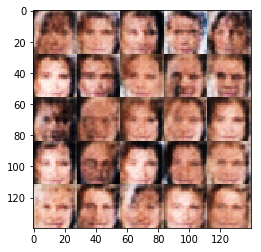

Epoch ... (1, 1)  Discriminator Loss:  1.42431  Generator Loss:  0.756764
Epoch ... (1, 1)  Discriminator Loss:  1.3455  Generator Loss:  0.725668
Epoch ... (1, 1)  Discriminator Loss:  1.28372  Generator Loss:  0.764551
Epoch ... (1, 1)  Discriminator Loss:  1.34204  Generator Loss:  0.807075
Epoch ... (1, 1)  Discriminator Loss:  1.33194  Generator Loss:  0.935671
Epoch ... (1, 1)  Discriminator Loss:  1.40728  Generator Loss:  0.825413
Epoch ... (1, 1)  Discriminator Loss:  1.28507  Generator Loss:  0.790373
Epoch ... (1, 1)  Discriminator Loss:  1.27615  Generator Loss:  0.837742
Epoch ... (1, 1)  Discriminator Loss:  1.29359  Generator Loss:  0.823606
Epoch ... (1, 1)  Discriminator Loss:  1.26333  Generator Loss:  0.77365
Training Value:  False
Tensor("generator_28/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


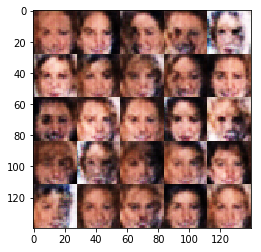

Epoch ... (1, 1)  Discriminator Loss:  1.38737  Generator Loss:  0.828904
Epoch ... (1, 1)  Discriminator Loss:  1.28993  Generator Loss:  0.852995
Epoch ... (1, 1)  Discriminator Loss:  1.27496  Generator Loss:  0.783945
Epoch ... (1, 1)  Discriminator Loss:  1.45845  Generator Loss:  0.750249
Epoch ... (1, 1)  Discriminator Loss:  1.25343  Generator Loss:  0.788539
Epoch ... (1, 1)  Discriminator Loss:  1.38448  Generator Loss:  0.789402
Epoch ... (1, 1)  Discriminator Loss:  1.455  Generator Loss:  0.751367
Epoch ... (1, 1)  Discriminator Loss:  1.27839  Generator Loss:  0.812701
Epoch ... (1, 1)  Discriminator Loss:  1.43187  Generator Loss:  0.731198
Epoch ... (1, 1)  Discriminator Loss:  1.3015  Generator Loss:  0.77176
Training Value:  False
Tensor("generator_29/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


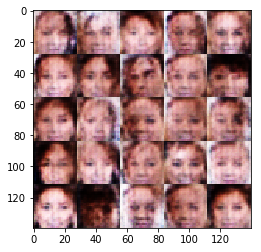

Epoch ... (1, 1)  Discriminator Loss:  1.2918  Generator Loss:  0.723042
Epoch ... (1, 1)  Discriminator Loss:  1.39027  Generator Loss:  0.755699
Epoch ... (1, 1)  Discriminator Loss:  1.32396  Generator Loss:  0.685401
Epoch ... (1, 1)  Discriminator Loss:  1.22848  Generator Loss:  0.757142
Epoch ... (1, 1)  Discriminator Loss:  1.48169  Generator Loss:  0.766337
Epoch ... (1, 1)  Discriminator Loss:  1.34137  Generator Loss:  0.720142
Epoch ... (1, 1)  Discriminator Loss:  1.19351  Generator Loss:  0.746505
Epoch ... (1, 1)  Discriminator Loss:  1.37148  Generator Loss:  0.863409
Epoch ... (1, 1)  Discriminator Loss:  1.38248  Generator Loss:  0.725597
Epoch ... (1, 1)  Discriminator Loss:  1.35062  Generator Loss:  0.747384
Training Value:  False
Tensor("generator_30/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


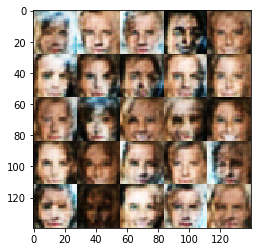

Epoch ... (1, 1)  Discriminator Loss:  1.3605  Generator Loss:  0.707096
Epoch ... (1, 1)  Discriminator Loss:  1.31153  Generator Loss:  0.811546
Epoch ... (1, 1)  Discriminator Loss:  1.35133  Generator Loss:  0.713765
Epoch ... (1, 1)  Discriminator Loss:  1.37152  Generator Loss:  0.806318
Epoch ... (1, 1)  Discriminator Loss:  1.39176  Generator Loss:  0.768633
Epoch ... (1, 1)  Discriminator Loss:  1.34127  Generator Loss:  0.799111
Epoch ... (1, 1)  Discriminator Loss:  1.35664  Generator Loss:  0.766353
Epoch ... (1, 1)  Discriminator Loss:  1.48261  Generator Loss:  0.671456
Epoch ... (1, 1)  Discriminator Loss:  1.32143  Generator Loss:  0.766998
Epoch ... (1, 1)  Discriminator Loss:  1.45424  Generator Loss:  0.872941
Training Value:  False
Tensor("generator_31/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


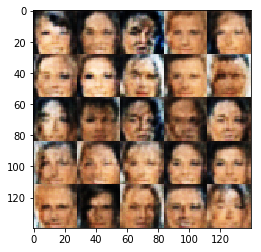

Epoch ... (1, 1)  Discriminator Loss:  1.36403  Generator Loss:  0.761862
Epoch ... (1, 1)  Discriminator Loss:  1.36667  Generator Loss:  0.733138
Epoch ... (1, 1)  Discriminator Loss:  1.41092  Generator Loss:  0.712203
Epoch ... (1, 1)  Discriminator Loss:  1.40179  Generator Loss:  0.742601
Epoch ... (1, 1)  Discriminator Loss:  1.3648  Generator Loss:  0.780357
Epoch ... (1, 1)  Discriminator Loss:  1.39678  Generator Loss:  0.813144
Epoch ... (1, 1)  Discriminator Loss:  1.35426  Generator Loss:  0.761763
Epoch ... (1, 1)  Discriminator Loss:  1.31193  Generator Loss:  0.787587
Epoch ... (1, 1)  Discriminator Loss:  1.27179  Generator Loss:  0.770923
Epoch ... (1, 1)  Discriminator Loss:  1.33349  Generator Loss:  0.78777
Training Value:  False
Tensor("generator_32/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


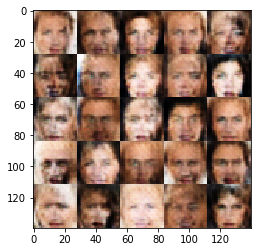

Epoch ... (1, 1)  Discriminator Loss:  1.42353  Generator Loss:  0.748378
Epoch ... (1, 1)  Discriminator Loss:  1.41873  Generator Loss:  0.745205
Epoch ... (1, 1)  Discriminator Loss:  1.39144  Generator Loss:  0.759197
Epoch ... (1, 1)  Discriminator Loss:  1.33596  Generator Loss:  0.722095
Epoch ... (1, 1)  Discriminator Loss:  1.27898  Generator Loss:  0.747799
Epoch ... (1, 1)  Discriminator Loss:  1.38585  Generator Loss:  0.694048
Epoch ... (1, 1)  Discriminator Loss:  1.35296  Generator Loss:  0.788026
Epoch ... (1, 1)  Discriminator Loss:  1.38146  Generator Loss:  0.707532
Epoch ... (1, 1)  Discriminator Loss:  1.33983  Generator Loss:  0.760298
Epoch ... (1, 1)  Discriminator Loss:  1.31323  Generator Loss:  0.756265
Training Value:  False
Tensor("generator_33/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


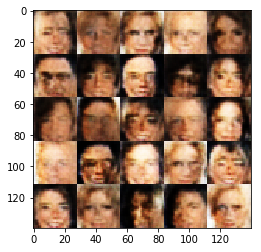

Epoch ... (1, 1)  Discriminator Loss:  1.36301  Generator Loss:  0.707997
Epoch ... (1, 1)  Discriminator Loss:  1.27687  Generator Loss:  0.831324
Epoch ... (1, 1)  Discriminator Loss:  1.45308  Generator Loss:  0.699739
Epoch ... (1, 1)  Discriminator Loss:  1.30648  Generator Loss:  0.847721
Epoch ... (1, 1)  Discriminator Loss:  1.32967  Generator Loss:  0.780132
Epoch ... (1, 1)  Discriminator Loss:  1.35896  Generator Loss:  0.783244
Epoch ... (1, 1)  Discriminator Loss:  1.35341  Generator Loss:  0.774817
Epoch ... (1, 1)  Discriminator Loss:  1.35047  Generator Loss:  0.79555
Epoch ... (1, 1)  Discriminator Loss:  1.30081  Generator Loss:  0.804159
Epoch ... (1, 1)  Discriminator Loss:  1.24507  Generator Loss:  0.720564
Training Value:  False
Tensor("generator_34/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


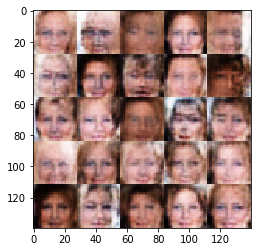

Epoch ... (1, 1)  Discriminator Loss:  1.40897  Generator Loss:  0.729946
Epoch ... (1, 1)  Discriminator Loss:  1.37427  Generator Loss:  0.791104
Epoch ... (1, 1)  Discriminator Loss:  1.35112  Generator Loss:  0.753639
Epoch ... (1, 1)  Discriminator Loss:  1.30384  Generator Loss:  0.727117
Epoch ... (1, 1)  Discriminator Loss:  1.35084  Generator Loss:  0.705936
Epoch ... (1, 1)  Discriminator Loss:  1.24343  Generator Loss:  0.80599
Epoch ... (1, 1)  Discriminator Loss:  1.50616  Generator Loss:  0.784295
Epoch ... (1, 1)  Discriminator Loss:  1.34451  Generator Loss:  0.76067
Epoch ... (1, 1)  Discriminator Loss:  1.25884  Generator Loss:  0.753058
Epoch ... (1, 1)  Discriminator Loss:  1.38758  Generator Loss:  0.728581
Training Value:  False
Tensor("generator_35/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


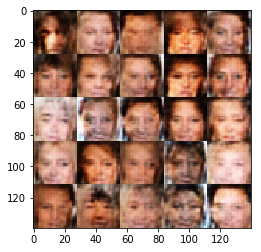

Epoch ... (1, 1)  Discriminator Loss:  1.2922  Generator Loss:  0.78132
Epoch ... (1, 1)  Discriminator Loss:  1.26861  Generator Loss:  0.856524
Epoch ... (1, 1)  Discriminator Loss:  1.32242  Generator Loss:  0.779287
Epoch ... (1, 1)  Discriminator Loss:  1.36965  Generator Loss:  0.748017
Epoch ... (1, 1)  Discriminator Loss:  1.40213  Generator Loss:  0.72657
Epoch ... (1, 1)  Discriminator Loss:  1.36902  Generator Loss:  0.698546
Epoch ... (1, 1)  Discriminator Loss:  1.34385  Generator Loss:  0.766482
Epoch ... (1, 1)  Discriminator Loss:  1.39371  Generator Loss:  0.749876
Epoch ... (1, 1)  Discriminator Loss:  1.36261  Generator Loss:  0.70528
Epoch ... (1, 1)  Discriminator Loss:  1.34356  Generator Loss:  0.695176
Training Value:  False
Tensor("generator_36/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


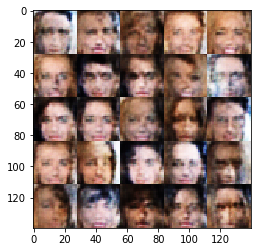

Epoch ... (1, 1)  Discriminator Loss:  1.3482  Generator Loss:  0.750495
Epoch ... (1, 1)  Discriminator Loss:  1.21385  Generator Loss:  0.744101
Epoch ... (1, 1)  Discriminator Loss:  1.35139  Generator Loss:  0.792558
Epoch ... (1, 1)  Discriminator Loss:  1.3554  Generator Loss:  0.792664
Epoch ... (1, 1)  Discriminator Loss:  1.41933  Generator Loss:  0.775308
Epoch ... (1, 1)  Discriminator Loss:  1.36041  Generator Loss:  0.812166
Epoch ... (1, 1)  Discriminator Loss:  1.27953  Generator Loss:  0.709949
Epoch ... (1, 1)  Discriminator Loss:  1.38305  Generator Loss:  0.776403
Epoch ... (1, 1)  Discriminator Loss:  1.35512  Generator Loss:  0.754708
Epoch ... (1, 1)  Discriminator Loss:  1.39672  Generator Loss:  0.733027
Training Value:  False
Tensor("generator_37/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


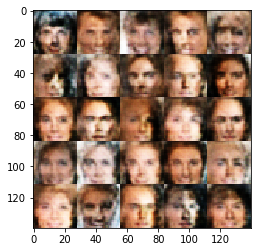

Epoch ... (1, 1)  Discriminator Loss:  1.46383  Generator Loss:  0.731253
Epoch ... (1, 1)  Discriminator Loss:  1.39144  Generator Loss:  0.763094
Epoch ... (1, 1)  Discriminator Loss:  1.376  Generator Loss:  0.79807
Epoch ... (1, 1)  Discriminator Loss:  1.37041  Generator Loss:  0.700899
Epoch ... (1, 1)  Discriminator Loss:  1.46275  Generator Loss:  0.73261
Epoch ... (1, 1)  Discriminator Loss:  1.40579  Generator Loss:  0.74244
Epoch ... (1, 1)  Discriminator Loss:  1.35563  Generator Loss:  0.750225
Epoch ... (1, 1)  Discriminator Loss:  1.36175  Generator Loss:  0.730802
Epoch ... (1, 1)  Discriminator Loss:  1.32916  Generator Loss:  0.774395
Epoch ... (1, 1)  Discriminator Loss:  1.36512  Generator Loss:  0.845981
Training Value:  False
Tensor("generator_38/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


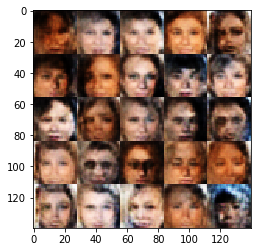

Epoch ... (1, 1)  Discriminator Loss:  1.36704  Generator Loss:  0.792882
Epoch ... (1, 1)  Discriminator Loss:  1.32616  Generator Loss:  0.747344
Epoch ... (1, 1)  Discriminator Loss:  1.41612  Generator Loss:  0.694249
Epoch ... (1, 1)  Discriminator Loss:  1.32891  Generator Loss:  0.724161
Epoch ... (1, 1)  Discriminator Loss:  1.36943  Generator Loss:  0.745812
Epoch ... (1, 1)  Discriminator Loss:  1.42186  Generator Loss:  0.744735
Epoch ... (1, 1)  Discriminator Loss:  1.37168  Generator Loss:  0.778956
Epoch ... (1, 1)  Discriminator Loss:  1.36865  Generator Loss:  0.729072
Epoch ... (1, 1)  Discriminator Loss:  1.39828  Generator Loss:  0.745671
Epoch ... (1, 1)  Discriminator Loss:  1.31402  Generator Loss:  0.759734
Training Value:  False
Tensor("generator_39/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


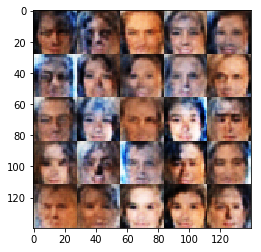

Epoch ... (1, 1)  Discriminator Loss:  1.37048  Generator Loss:  0.828515
Epoch ... (1, 1)  Discriminator Loss:  1.38622  Generator Loss:  0.72689
Epoch ... (1, 1)  Discriminator Loss:  1.3689  Generator Loss:  0.820837
Epoch ... (1, 1)  Discriminator Loss:  1.30182  Generator Loss:  0.756068
Epoch ... (1, 1)  Discriminator Loss:  1.39636  Generator Loss:  0.702219
Epoch ... (1, 1)  Discriminator Loss:  1.37417  Generator Loss:  0.706541
Epoch ... (1, 1)  Discriminator Loss:  1.36582  Generator Loss:  0.682769
Epoch ... (1, 1)  Discriminator Loss:  1.34554  Generator Loss:  0.763273
Epoch ... (1, 1)  Discriminator Loss:  1.40736  Generator Loss:  0.738296
Epoch ... (1, 1)  Discriminator Loss:  1.32914  Generator Loss:  0.774361
Training Value:  False
Tensor("generator_40/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


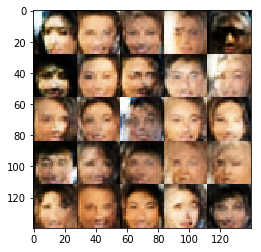

Epoch ... (1, 1)  Discriminator Loss:  1.31843  Generator Loss:  0.746843
Epoch ... (1, 1)  Discriminator Loss:  1.36577  Generator Loss:  0.807986
Epoch ... (1, 1)  Discriminator Loss:  1.3313  Generator Loss:  0.784495
Epoch ... (1, 1)  Discriminator Loss:  1.38426  Generator Loss:  0.766682
Epoch ... (1, 1)  Discriminator Loss:  1.35173  Generator Loss:  0.740235
Epoch ... (1, 1)  Discriminator Loss:  1.35028  Generator Loss:  0.764556
Epoch ... (1, 1)  Discriminator Loss:  1.33939  Generator Loss:  0.841005
Epoch ... (1, 1)  Discriminator Loss:  1.36923  Generator Loss:  0.76082
Epoch ... (1, 1)  Discriminator Loss:  1.35107  Generator Loss:  0.70385
Epoch ... (1, 1)  Discriminator Loss:  1.39703  Generator Loss:  0.708268
Training Value:  False
Tensor("generator_41/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


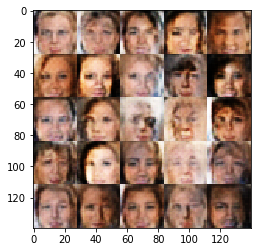

Epoch ... (1, 1)  Discriminator Loss:  1.37493  Generator Loss:  0.731312
Epoch ... (1, 1)  Discriminator Loss:  1.34242  Generator Loss:  0.788445
Epoch ... (1, 1)  Discriminator Loss:  1.3871  Generator Loss:  0.775042
Epoch ... (1, 1)  Discriminator Loss:  1.36995  Generator Loss:  0.684923
Epoch ... (1, 1)  Discriminator Loss:  1.35444  Generator Loss:  0.711347
Epoch ... (1, 1)  Discriminator Loss:  1.32696  Generator Loss:  0.736098
Epoch ... (1, 1)  Discriminator Loss:  1.39105  Generator Loss:  0.746149
Epoch ... (1, 1)  Discriminator Loss:  1.36639  Generator Loss:  0.767527
Epoch ... (1, 1)  Discriminator Loss:  1.3351  Generator Loss:  0.749863
Epoch ... (1, 1)  Discriminator Loss:  1.35723  Generator Loss:  0.717744
Training Value:  False
Tensor("generator_42/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


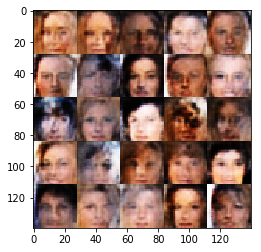

Epoch ... (1, 1)  Discriminator Loss:  1.35942  Generator Loss:  0.730685
Epoch ... (1, 1)  Discriminator Loss:  1.33716  Generator Loss:  0.760568
Epoch ... (1, 1)  Discriminator Loss:  1.42226  Generator Loss:  0.72347
Epoch ... (1, 1)  Discriminator Loss:  1.33083  Generator Loss:  0.705446
Epoch ... (1, 1)  Discriminator Loss:  1.35958  Generator Loss:  0.67459
Epoch ... (1, 1)  Discriminator Loss:  1.28919  Generator Loss:  0.794698
Epoch ... (1, 1)  Discriminator Loss:  1.41206  Generator Loss:  0.72149
Epoch ... (1, 1)  Discriminator Loss:  1.42057  Generator Loss:  0.762708
Epoch ... (1, 1)  Discriminator Loss:  1.3582  Generator Loss:  0.777501
Epoch ... (1, 1)  Discriminator Loss:  1.38868  Generator Loss:  0.696318
Training Value:  False
Tensor("generator_43/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


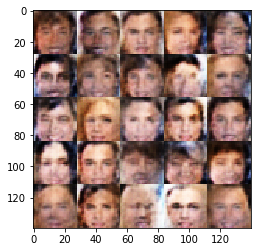

Epoch ... (1, 1)  Discriminator Loss:  1.39775  Generator Loss:  0.71629
Epoch ... (1, 1)  Discriminator Loss:  1.29336  Generator Loss:  0.713227
Epoch ... (1, 1)  Discriminator Loss:  1.41058  Generator Loss:  0.792882
Epoch ... (1, 1)  Discriminator Loss:  1.39765  Generator Loss:  0.807598
Epoch ... (1, 1)  Discriminator Loss:  1.35471  Generator Loss:  0.729289
Epoch ... (1, 1)  Discriminator Loss:  1.31737  Generator Loss:  0.785513
Epoch ... (1, 1)  Discriminator Loss:  1.39229  Generator Loss:  0.719999
Epoch ... (1, 1)  Discriminator Loss:  1.39095  Generator Loss:  0.725577
Epoch ... (1, 1)  Discriminator Loss:  1.36961  Generator Loss:  0.636716
Epoch ... (1, 1)  Discriminator Loss:  1.40818  Generator Loss:  0.735252
Training Value:  False
Tensor("generator_44/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


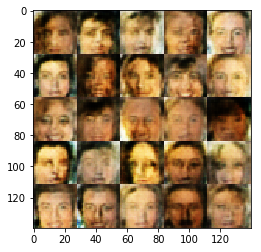

Epoch ... (1, 1)  Discriminator Loss:  1.3418  Generator Loss:  0.782391
Epoch ... (1, 1)  Discriminator Loss:  1.36272  Generator Loss:  0.740634
Epoch ... (1, 1)  Discriminator Loss:  1.36773  Generator Loss:  0.687483
Epoch ... (1, 1)  Discriminator Loss:  1.39776  Generator Loss:  0.709772
Epoch ... (1, 1)  Discriminator Loss:  1.35217  Generator Loss:  0.654673
Epoch ... (1, 1)  Discriminator Loss:  1.38512  Generator Loss:  0.834677
Epoch ... (1, 1)  Discriminator Loss:  1.39518  Generator Loss:  0.823176
Epoch ... (1, 1)  Discriminator Loss:  1.37948  Generator Loss:  0.713876
Epoch ... (1, 1)  Discriminator Loss:  1.36347  Generator Loss:  0.720454
Epoch ... (1, 1)  Discriminator Loss:  1.3636  Generator Loss:  0.724536
Training Value:  False
Tensor("generator_45/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


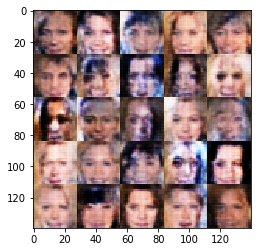

Epoch ... (1, 1)  Discriminator Loss:  1.34621  Generator Loss:  0.759628
Epoch ... (1, 1)  Discriminator Loss:  1.35818  Generator Loss:  0.725278
Epoch ... (1, 1)  Discriminator Loss:  1.38433  Generator Loss:  0.667518
Epoch ... (1, 1)  Discriminator Loss:  1.40676  Generator Loss:  0.819122
Epoch ... (1, 1)  Discriminator Loss:  1.36835  Generator Loss:  0.838041
Epoch ... (1, 1)  Discriminator Loss:  1.35665  Generator Loss:  0.746087
Epoch ... (1, 1)  Discriminator Loss:  1.38858  Generator Loss:  0.709566
Epoch ... (1, 1)  Discriminator Loss:  1.34715  Generator Loss:  0.732066
Epoch ... (1, 1)  Discriminator Loss:  1.37044  Generator Loss:  0.771528
Epoch ... (1, 1)  Discriminator Loss:  1.35994  Generator Loss:  0.758144
Training Value:  False
Tensor("generator_46/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


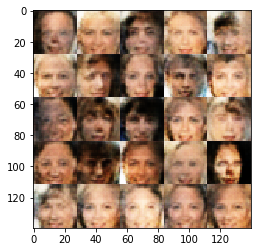

Epoch ... (1, 1)  Discriminator Loss:  1.36929  Generator Loss:  0.708352
Epoch ... (1, 1)  Discriminator Loss:  1.42364  Generator Loss:  0.763909
Epoch ... (1, 1)  Discriminator Loss:  1.35905  Generator Loss:  0.752907
Epoch ... (1, 1)  Discriminator Loss:  1.32773  Generator Loss:  0.749678
Epoch ... (1, 1)  Discriminator Loss:  1.36384  Generator Loss:  0.75985
Epoch ... (1, 1)  Discriminator Loss:  1.37845  Generator Loss:  0.774884
Epoch ... (1, 1)  Discriminator Loss:  1.3611  Generator Loss:  0.74517
Epoch ... (1, 1)  Discriminator Loss:  1.3802  Generator Loss:  0.707096
Epoch ... (1, 1)  Discriminator Loss:  1.3702  Generator Loss:  0.744384
Epoch ... (1, 1)  Discriminator Loss:  1.3711  Generator Loss:  0.712001
Training Value:  False
Tensor("generator_47/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


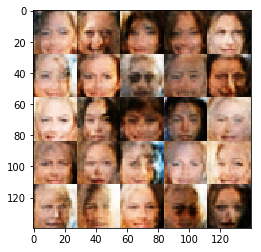

Epoch ... (1, 1)  Discriminator Loss:  1.35454  Generator Loss:  0.706244
Epoch ... (1, 1)  Discriminator Loss:  1.33602  Generator Loss:  0.741199
Epoch ... (1, 1)  Discriminator Loss:  1.30822  Generator Loss:  0.784578
Epoch ... (1, 1)  Discriminator Loss:  1.38101  Generator Loss:  0.736135
Epoch ... (1, 1)  Discriminator Loss:  1.43285  Generator Loss:  0.721661
Epoch ... (1, 1)  Discriminator Loss:  1.3489  Generator Loss:  0.709309
Epoch ... (1, 1)  Discriminator Loss:  1.38043  Generator Loss:  0.710747
Epoch ... (1, 1)  Discriminator Loss:  1.34346  Generator Loss:  0.716112
Epoch ... (1, 1)  Discriminator Loss:  1.39868  Generator Loss:  0.762141
Epoch ... (1, 1)  Discriminator Loss:  1.33329  Generator Loss:  0.781489
Training Value:  False
Tensor("generator_48/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


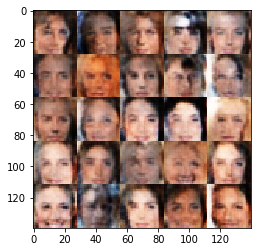

Epoch ... (1, 1)  Discriminator Loss:  1.37929  Generator Loss:  0.746577
Epoch ... (1, 1)  Discriminator Loss:  1.3679  Generator Loss:  0.730272
Epoch ... (1, 1)  Discriminator Loss:  1.32094  Generator Loss:  0.745076
Epoch ... (1, 1)  Discriminator Loss:  1.37426  Generator Loss:  0.770774
Epoch ... (1, 1)  Discriminator Loss:  1.30473  Generator Loss:  0.731551
Epoch ... (1, 1)  Discriminator Loss:  1.40402  Generator Loss:  0.715358
Epoch ... (1, 1)  Discriminator Loss:  1.32246  Generator Loss:  0.770628
Epoch ... (1, 1)  Discriminator Loss:  1.37447  Generator Loss:  0.704179
Epoch ... (1, 1)  Discriminator Loss:  1.36935  Generator Loss:  0.744115
Epoch ... (1, 1)  Discriminator Loss:  1.37207  Generator Loss:  0.71703
Training Value:  False
Tensor("generator_49/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


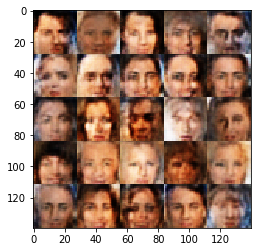

Epoch ... (1, 1)  Discriminator Loss:  1.34544  Generator Loss:  0.745046
Epoch ... (1, 1)  Discriminator Loss:  1.33742  Generator Loss:  0.734284
Epoch ... (1, 1)  Discriminator Loss:  1.35191  Generator Loss:  0.818887
Epoch ... (1, 1)  Discriminator Loss:  1.34749  Generator Loss:  0.716076
Epoch ... (1, 1)  Discriminator Loss:  1.36328  Generator Loss:  0.713078
Epoch ... (1, 1)  Discriminator Loss:  1.41258  Generator Loss:  0.645265
Epoch ... (1, 1)  Discriminator Loss:  1.36188  Generator Loss:  0.719919
Epoch ... (1, 1)  Discriminator Loss:  1.4372  Generator Loss:  0.79276
Epoch ... (1, 1)  Discriminator Loss:  1.35876  Generator Loss:  0.773289
Epoch ... (1, 1)  Discriminator Loss:  1.33073  Generator Loss:  0.729548
Training Value:  False
Tensor("generator_50/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


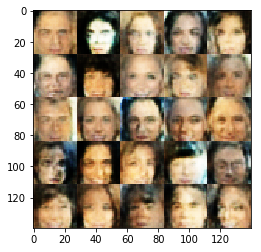

Epoch ... (1, 1)  Discriminator Loss:  1.42376  Generator Loss:  0.762947
Epoch ... (1, 1)  Discriminator Loss:  1.36734  Generator Loss:  0.708943
Epoch ... (1, 1)  Discriminator Loss:  1.2951  Generator Loss:  0.789894
Epoch ... (1, 1)  Discriminator Loss:  1.40755  Generator Loss:  0.77395
Epoch ... (1, 1)  Discriminator Loss:  1.36253  Generator Loss:  0.767472
Epoch ... (1, 1)  Discriminator Loss:  1.33494  Generator Loss:  0.693908
Epoch ... (1, 1)  Discriminator Loss:  1.43349  Generator Loss:  0.747131
Epoch ... (1, 1)  Discriminator Loss:  1.34627  Generator Loss:  0.745077
Epoch ... (1, 1)  Discriminator Loss:  1.35068  Generator Loss:  0.754809
Epoch ... (1, 1)  Discriminator Loss:  1.34708  Generator Loss:  0.78372
Training Value:  False
Tensor("generator_51/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


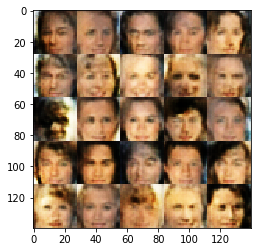

Epoch ... (1, 1)  Discriminator Loss:  1.36482  Generator Loss:  0.780132
Epoch ... (1, 1)  Discriminator Loss:  1.33486  Generator Loss:  0.724525
Epoch ... (1, 1)  Discriminator Loss:  1.34206  Generator Loss:  0.724949
Epoch ... (1, 1)  Discriminator Loss:  1.35643  Generator Loss:  0.70653
Epoch ... (1, 1)  Discriminator Loss:  1.42168  Generator Loss:  0.76603
Epoch ... (1, 1)  Discriminator Loss:  1.38375  Generator Loss:  0.768089
Epoch ... (1, 1)  Discriminator Loss:  1.33043  Generator Loss:  0.740843
Epoch ... (1, 1)  Discriminator Loss:  1.36121  Generator Loss:  0.789331
Epoch ... (1, 1)  Discriminator Loss:  1.3354  Generator Loss:  0.733992
Epoch ... (1, 1)  Discriminator Loss:  1.31544  Generator Loss:  0.750301
Training Value:  False
Tensor("generator_52/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


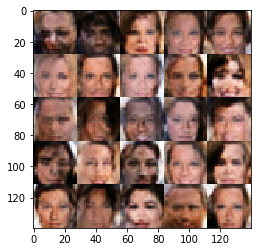

Epoch ... (1, 1)  Discriminator Loss:  1.42054  Generator Loss:  0.725573
Epoch ... (1, 1)  Discriminator Loss:  1.37497  Generator Loss:  0.715606
Epoch ... (1, 1)  Discriminator Loss:  1.37174  Generator Loss:  0.797191
Epoch ... (1, 1)  Discriminator Loss:  1.3174  Generator Loss:  0.786803
Epoch ... (1, 1)  Discriminator Loss:  1.3217  Generator Loss:  0.714173
Epoch ... (1, 1)  Discriminator Loss:  1.37434  Generator Loss:  0.729418
Epoch ... (1, 1)  Discriminator Loss:  1.30757  Generator Loss:  0.808697
Epoch ... (1, 1)  Discriminator Loss:  1.40511  Generator Loss:  0.729357
Epoch ... (1, 1)  Discriminator Loss:  1.40562  Generator Loss:  0.771119
Epoch ... (1, 1)  Discriminator Loss:  1.3533  Generator Loss:  0.703922
Training Value:  False
Tensor("generator_53/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


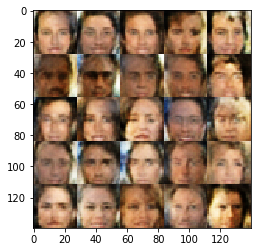

Epoch ... (1, 1)  Discriminator Loss:  1.35338  Generator Loss:  0.782955
Epoch ... (1, 1)  Discriminator Loss:  1.37723  Generator Loss:  0.647708
Epoch ... (1, 1)  Discriminator Loss:  1.33095  Generator Loss:  0.702525
Epoch ... (1, 1)  Discriminator Loss:  1.42529  Generator Loss:  0.715432
Epoch ... (1, 1)  Discriminator Loss:  1.3847  Generator Loss:  0.806874
Epoch ... (1, 1)  Discriminator Loss:  1.34067  Generator Loss:  0.804633
Epoch ... (1, 1)  Discriminator Loss:  1.39278  Generator Loss:  0.68123
Epoch ... (1, 1)  Discriminator Loss:  1.32403  Generator Loss:  0.742382
Epoch ... (1, 1)  Discriminator Loss:  1.37152  Generator Loss:  0.754295
Epoch ... (1, 1)  Discriminator Loss:  1.33357  Generator Loss:  0.7608
Training Value:  False
Tensor("generator_54/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


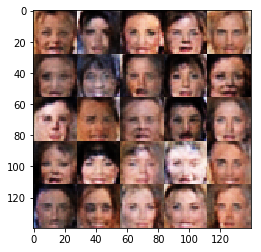

Epoch ... (1, 1)  Discriminator Loss:  1.36264  Generator Loss:  0.80536
Epoch ... (1, 1)  Discriminator Loss:  1.3584  Generator Loss:  0.751688
Epoch ... (1, 1)  Discriminator Loss:  1.38395  Generator Loss:  0.695196
Epoch ... (1, 1)  Discriminator Loss:  1.36308  Generator Loss:  0.70838
Epoch ... (1, 1)  Discriminator Loss:  1.38093  Generator Loss:  0.780009
Epoch ... (1, 1)  Discriminator Loss:  1.31421  Generator Loss:  0.751473
Epoch ... (1, 1)  Discriminator Loss:  1.42058  Generator Loss:  0.759928
Epoch ... (1, 1)  Discriminator Loss:  1.43075  Generator Loss:  0.761707
Epoch ... (1, 1)  Discriminator Loss:  1.37053  Generator Loss:  0.733815
Epoch ... (1, 1)  Discriminator Loss:  1.28922  Generator Loss:  0.690087
Training Value:  False
Tensor("generator_55/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


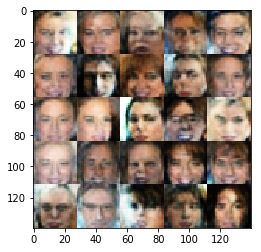

Epoch ... (1, 1)  Discriminator Loss:  1.4108  Generator Loss:  0.775737
Epoch ... (1, 1)  Discriminator Loss:  1.36478  Generator Loss:  0.712263
Epoch ... (1, 1)  Discriminator Loss:  1.37492  Generator Loss:  0.857429
Epoch ... (1, 1)  Discriminator Loss:  1.394  Generator Loss:  0.800475
Epoch ... (1, 1)  Discriminator Loss:  1.3797  Generator Loss:  0.744308
Epoch ... (1, 1)  Discriminator Loss:  1.34491  Generator Loss:  0.705105
Epoch ... (1, 1)  Discriminator Loss:  1.36608  Generator Loss:  0.700281
Epoch ... (1, 1)  Discriminator Loss:  1.37233  Generator Loss:  0.695065
Epoch ... (1, 1)  Discriminator Loss:  1.33082  Generator Loss:  0.726175
Epoch ... (1, 1)  Discriminator Loss:  1.4008  Generator Loss:  0.744971
Training Value:  False
Tensor("generator_56/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


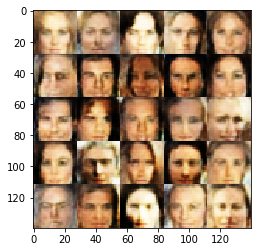

Epoch ... (1, 1)  Discriminator Loss:  1.41001  Generator Loss:  0.74077
Epoch ... (1, 1)  Discriminator Loss:  1.37817  Generator Loss:  0.785094
Epoch ... (1, 1)  Discriminator Loss:  1.38225  Generator Loss:  0.798355
Epoch ... (1, 1)  Discriminator Loss:  1.34931  Generator Loss:  0.772731
Epoch ... (1, 1)  Discriminator Loss:  1.35553  Generator Loss:  0.785869
Epoch ... (1, 1)  Discriminator Loss:  1.3971  Generator Loss:  0.764586
Epoch ... (1, 1)  Discriminator Loss:  1.39741  Generator Loss:  0.763975
Epoch ... (1, 1)  Discriminator Loss:  1.41825  Generator Loss:  0.743495
Epoch ... (1, 1)  Discriminator Loss:  1.37761  Generator Loss:  0.722228
Epoch ... (1, 1)  Discriminator Loss:  1.3783  Generator Loss:  0.738961
Training Value:  False
Tensor("generator_57/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


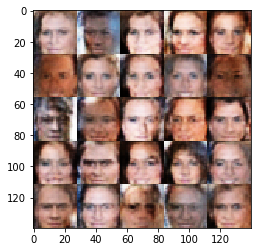

Epoch ... (1, 1)  Discriminator Loss:  1.30872  Generator Loss:  0.683312
Epoch ... (1, 1)  Discriminator Loss:  1.31312  Generator Loss:  0.770793
Epoch ... (1, 1)  Discriminator Loss:  1.41636  Generator Loss:  0.766066
Epoch ... (1, 1)  Discriminator Loss:  1.39517  Generator Loss:  0.697281
Epoch ... (1, 1)  Discriminator Loss:  1.31121  Generator Loss:  0.755137
Epoch ... (1, 1)  Discriminator Loss:  1.34098  Generator Loss:  0.789304
Epoch ... (1, 1)  Discriminator Loss:  1.37268  Generator Loss:  0.754058
Epoch ... (1, 1)  Discriminator Loss:  1.33897  Generator Loss:  0.724306
Epoch ... (1, 1)  Discriminator Loss:  1.37629  Generator Loss:  0.707741
Epoch ... (1, 1)  Discriminator Loss:  1.34864  Generator Loss:  0.774012
Training Value:  False
Tensor("generator_58/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


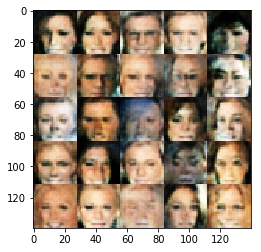

Epoch ... (1, 1)  Discriminator Loss:  1.38621  Generator Loss:  0.771059
Epoch ... (1, 1)  Discriminator Loss:  1.34395  Generator Loss:  0.752961
Epoch ... (1, 1)  Discriminator Loss:  1.38077  Generator Loss:  0.727986
Epoch ... (1, 1)  Discriminator Loss:  1.3451  Generator Loss:  0.712478
Epoch ... (1, 1)  Discriminator Loss:  1.34862  Generator Loss:  0.779413
Epoch ... (1, 1)  Discriminator Loss:  1.43637  Generator Loss:  0.717628
Epoch ... (1, 1)  Discriminator Loss:  1.39442  Generator Loss:  0.727902
Epoch ... (1, 1)  Discriminator Loss:  1.37471  Generator Loss:  0.684344
Epoch ... (1, 1)  Discriminator Loss:  1.34061  Generator Loss:  0.684635
Epoch ... (1, 1)  Discriminator Loss:  1.34298  Generator Loss:  0.778598
Training Value:  False
Tensor("generator_59/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


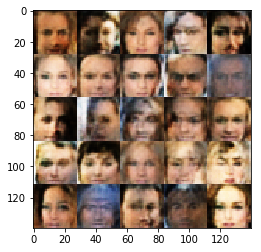

Epoch ... (1, 1)  Discriminator Loss:  1.40776  Generator Loss:  0.792248
Epoch ... (1, 1)  Discriminator Loss:  1.32688  Generator Loss:  0.695475
Epoch ... (1, 1)  Discriminator Loss:  1.42316  Generator Loss:  0.670449
Epoch ... (1, 1)  Discriminator Loss:  1.38794  Generator Loss:  0.753035
Epoch ... (1, 1)  Discriminator Loss:  1.39957  Generator Loss:  0.729791
Epoch ... (1, 1)  Discriminator Loss:  1.40466  Generator Loss:  0.754173
Epoch ... (1, 1)  Discriminator Loss:  1.39287  Generator Loss:  0.755483
Epoch ... (1, 1)  Discriminator Loss:  1.3868  Generator Loss:  0.775493
Epoch ... (1, 1)  Discriminator Loss:  1.3527  Generator Loss:  0.675652
Epoch ... (1, 1)  Discriminator Loss:  1.37078  Generator Loss:  0.739443
Training Value:  False
Tensor("generator_60/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


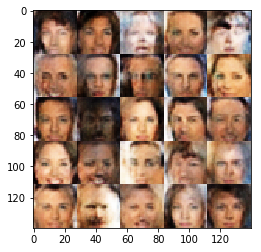

Epoch ... (1, 1)  Discriminator Loss:  1.36207  Generator Loss:  0.769805
Epoch ... (1, 1)  Discriminator Loss:  1.39542  Generator Loss:  0.697705
Epoch ... (1, 1)  Discriminator Loss:  1.2996  Generator Loss:  0.656694
Epoch ... (1, 1)  Discriminator Loss:  1.37127  Generator Loss:  0.684396
Epoch ... (1, 1)  Discriminator Loss:  1.36401  Generator Loss:  0.641539
Epoch ... (1, 1)  Discriminator Loss:  1.40183  Generator Loss:  0.740661
Epoch ... (1, 1)  Discriminator Loss:  1.37638  Generator Loss:  0.742636
Epoch ... (1, 1)  Discriminator Loss:  1.35297  Generator Loss:  0.723741
Epoch ... (1, 1)  Discriminator Loss:  1.38592  Generator Loss:  0.80479
Epoch ... (1, 1)  Discriminator Loss:  1.3548  Generator Loss:  0.829444
Training Value:  False
Tensor("generator_61/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


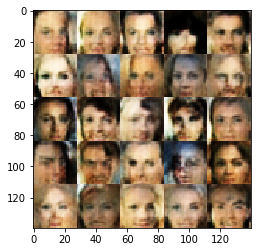

Epoch ... (1, 1)  Discriminator Loss:  1.2936  Generator Loss:  0.700117
Epoch ... (1, 1)  Discriminator Loss:  1.35715  Generator Loss:  0.73209
Epoch ... (1, 1)  Discriminator Loss:  1.32842  Generator Loss:  0.679537
Epoch ... (1, 1)  Discriminator Loss:  1.335  Generator Loss:  0.773027
Epoch ... (1, 1)  Discriminator Loss:  1.39909  Generator Loss:  0.809034
Epoch ... (1, 1)  Discriminator Loss:  1.32512  Generator Loss:  0.713475
Epoch ... (1, 1)  Discriminator Loss:  1.3558  Generator Loss:  0.647315
Epoch ... (1, 1)  Discriminator Loss:  1.379  Generator Loss:  0.792774
Epoch ... (1, 1)  Discriminator Loss:  1.36027  Generator Loss:  0.739045
Epoch ... (1, 1)  Discriminator Loss:  1.436  Generator Loss:  0.821064
Training Value:  False
Tensor("generator_62/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


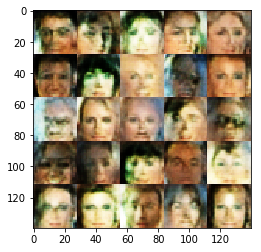

Epoch ... (1, 1)  Discriminator Loss:  1.38642  Generator Loss:  0.76453
Epoch ... (1, 1)  Discriminator Loss:  1.38041  Generator Loss:  0.71843
Epoch ... (1, 1)  Discriminator Loss:  1.36657  Generator Loss:  0.729496
Epoch ... (1, 1)  Discriminator Loss:  1.3721  Generator Loss:  0.732545
Epoch ... (1, 1)  Discriminator Loss:  1.3385  Generator Loss:  0.72027
Epoch ... (1, 1)  Discriminator Loss:  1.36977  Generator Loss:  0.816173
Epoch ... (1, 1)  Discriminator Loss:  1.28765  Generator Loss:  0.758258
Epoch ... (1, 1)  Discriminator Loss:  1.38973  Generator Loss:  0.762697
Epoch ... (1, 1)  Discriminator Loss:  1.40223  Generator Loss:  0.769798
Epoch ... (1, 1)  Discriminator Loss:  1.38397  Generator Loss:  0.722625
Training Value:  False
Tensor("generator_63/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


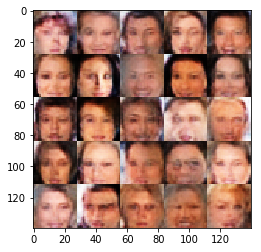

Epoch ... (1, 1)  Discriminator Loss:  1.36366  Generator Loss:  0.769416
Epoch ... (1, 1)  Discriminator Loss:  1.39258  Generator Loss:  0.753263
Epoch ... (1, 1)  Discriminator Loss:  1.40802  Generator Loss:  0.73933


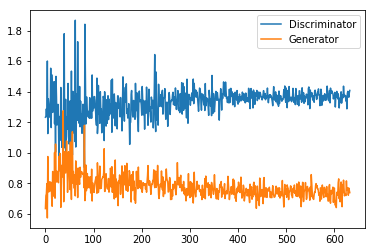

In [45]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.